# TDSM encoder
Here we provide interactive scripts, with which one can study input features, hyperparameters and finally perform the training & sampling of generative model. All of these scripts use classes and functions used in the code that runs on condor in order to obtain the optimised model trained on the full dataset. We advise not to train the model on the full dataset here as it will take too long. We advise to limit the training dataset size and number of epochs and use this notebook to study pre-processing, hyperparameters and diffusion techniques.

## Import model
First, we set the environment and the various parameters for the model, hyperparameters, diffusion equations etc. We also create instances of the stochastic differential equations, machine learning model and create a list of files we want to use as input.

Important: need to set the padding value to the value used in pad_events.py script to create the padded (and transformed) dataset.

In [1]:
import time, functools, torch, os,sys, random, fnmatch, psutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam,RAdam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import trans_tdsm, utils
from prettytable import PrettyTable
import util.dataset_structure, util.display, util.model
import tqdm
from pickle import load
from IPython import display

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set the value used to pad events in pad_events.py
padding_value = 0.0

dataset = "dataset_1_photons_padded_nentry"
#dataset_store_path = "/eos/user/j/jthomasw/tdsm_encoder/datasets/minmax_transformer/"
dataset_store_path = "/eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/"
#dataset_store_path = "/eos/user/j/jthomasw/tdsm_encoder/datasets/power_transformer/"
transform = None
transform_y = None
mask = True
jupyternotebook = True

workingdir = "./"
### HYPERPARAMETERS ###
train_ratio = 0.8
batch_size = 64
lr = 0.0001
n_epochs = 100
### SDE PARAMETERS ###
SDE = 'VP'
if SDE == 'VP':
    beta_max = 50.0
    beta_min = 0.1
if SDE == 'VE':
    sigma_max = 20.0
    sigma_min = 0.1
### MODEL PARAMETERS ###
n_feat_dim = 4
embed_dim = 512
hidden_dim = 128
num_encoder_blocks = 3
num_attn_heads = 8
dropout_gen = 0

# Instantiate stochastic differential equation
if SDE == 'VP':
    sde = utils.VPSDE(beta_max=beta_max,beta_min=beta_min, device=device)
if SDE == 'VE':
    sde = utils.VESDE(sigma_max=sigma_max,sigma_min=sigma_min,device=device)
marginal_prob_std_fn = functools.partial(sde.marginal_prob)
diffusion_coeff_fn = functools.partial(sde.sde)

print('torch version: ', torch.__version__)
print('Running on device: ', device)
if torch.cuda.is_available():
    print('Cuda used to build pyTorch: ',torch.version.cuda)
    print('Current device: ', torch.cuda.current_device())
    print('Cuda arch list: ', torch.cuda.get_arch_list())

print('Working directory: ', workingdir)

files_list_ = []
for filename in os.listdir(dataset_store_path):
    #if fnmatch.fnmatch(filename, dataset + '12*.pt') or fnmatch.fnmatch(filename, dataset + '21*.pt') or fnmatch.fnmatch(filename, dataset + '30*.pt'):
    if fnmatch.fnmatch(filename, dataset + '1*.pt'):
        files_list_.append(os.path.join(dataset_store_path, filename))
print(files_list_)

model=trans_tdsm.Gen(n_feat_dim, embed_dim, hidden_dim, num_encoder_blocks, num_attn_heads, dropout_gen, marginal_prob_std=marginal_prob_std_fn)

table = PrettyTable(['Module name', 'Parameters listed'])
t_params = 0
for name_ , para_ in model.named_parameters():
    if not para_.requires_grad: continue
    param = para_.numel()
    table.add_row([name_, param])
    t_params+=param
print(table)
print(f'Sum of trainable parameters: {t_params}')    

torch version:  1.11.0a0+gitbc2c6ed
Running on device:  cuda
Cuda used to build pyTorch:  11.2
Current device:  0
Cuda arch list:  ['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'compute_37']
Working directory:  ./
['/eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry121To150.pt', '/eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry151To180.pt', '/eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry181To210.pt', '/eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry1To30.pt']
+--------------------------------+-------------------+
|          Module name           | Parameters listed |
+--------------------------------+-------------------+
|           cls_token            |        512        |
|          embed.weight          |        2048       |
|           embed.bias           |        512        |
|        embed_t.1.weight        |       262144      |
|         

## Plot data distribution

Display distributions of either the transformed or non-transformed input features. This is one way of inspecting how the transformation is affecting the distributions input to the training. Transforming data is an important part of the pre-processing stage of machine learning projects. We want to ensure that the input features have distributions that are as easy as possible for the machine learning algorithm to learn and that features have a similar numerical range, to avoid the task of loss minimisation shifting focus to a single variable. One commonly used way of doing this is to transform variables to have a Gaussian like distribution. In order to choose the transformation function that is best for your data, it is important to study the data and how the transformation affects your distributions. Note that pre-processing data can be one of the most time consuming aspects of a machine learning project and can have a profound affect on the success of the project, so take your time here.

Training is always performed using the transformed inputs where available. The `energy_trans_file` argument should be the pickle file containing fitted input transformation function. Only provide a file name if you want to plot distributions where the transformation has been inverted and applied to inputs to transform back to the original distributions. In such cases, if you want to check the inverted transformation is doing the correct inversion, compare for a single file against the plots inside the directory:

`
datasets/<transformation>/featureplots_dataset
`

Plots of the inverted transformation should be similar to what is shown in those, though not identical as we only plot a subset of the showers.

#### Choice of transformation
What we don't want in our dataset:

1. Negative values are currently problematic given the loss function and subsequent diffusion paradigm we have chosen. The precise mathematical reasoning need to be ironed out, however it leads to a runaway effect when generating showers that produces more and more negative values.

2. Due to point 1, our padding value is set to zero and hence we don't want a distribution for the features that includes zero.

The dataset contains a wide range of hit energies that has a few outliers with incredibly high energy so we need a transformation for hit energy that is robust to outliers. Hence, I have tried to use the quantile transformation to uniform distribution and put an offset of '+1' to avoid zero (padding) values. MinMax works to some degree, but due to the extremely high valued energy outliers, when we extract the values from the distribution for the transformation, the outliers skew everything, rendering some of the small hit energy values extremely small, hence they are all very close to the lower bound of the distribution. This might make their distribution difficult for the model to learn, as they are all very close together for e.g. the bucket with 1 to 30 hits.

The X and Y position distributions don't have such extreme outliers so we don't need the robustness to outliers in the transformation. When using e.g. quantile transformation to uniform however, the zero values in the Y position create a huge peak and the absence of such values in the X create a discontinuity in the X position distribution. Transforming to a quantile gaussian creates quite a wide distribution with negative values so ofsetting this to be positive would require some fine-tuning of the offset that is a bit fiddly. So for the X and Y I have chosen the to use a minmax transformation, setting the range to (1,2) to avoid padding values.

### Transformations

#### Quantile gaussian transformation:
Non-linear transformation that maps the probability density function of each feature to a gaussian distribution, including outliers. Lower numbers become smaller and eventually negative.

#### Quantile uniform transformation:
Non-linear transformation that maps the probability density function of each feature to a uniform distribution, including outliers. Lower numbers become smaller and eventually negative.

#### Power transformation:
Stabilises against variance and skew by applying a power transformation to each variable to make them more gaussian-like.

#### MinMax transformation:
Transforms all data to predetermined range. The default range will be between 0-1.
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

# showers to plot: 1000
plot_distribution running on input type 'files'
Loading file for hit e transformation inversion: /eos/user/j/jthomasw/tdsm_encoder/datasets/minmax_transformer/transform_e.pkl
Loading file for hit x transformation inversion: /eos/user/j/jthomasw/tdsm_encoder/datasets/minmax_transformer/transform_x.pkl
Loading file for hit y transformation inversion: /eos/user/j/jthomasw/tdsm_encoder/datasets/minmax_transformer/transform_y.pkl
# files: 1
# showers per file: [1000]
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/minmax_transformer/dataset_1_photons_padded_nentry121To150.pt
# batches: 14635
# showers to plot: 1000
plot_distribution running on input type 'files'
# files: 1
# showers per file: [1000]
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/minmax_transformer/dataset_1_photons_padded_nentry121To150.pt
# batches: 14635
Plot # entries
Plot hit energies
Plot hit x
Plot hit y
Plot hit z
Plot incident energies
Plot total deposited hit energy per shower
Plot av. X 

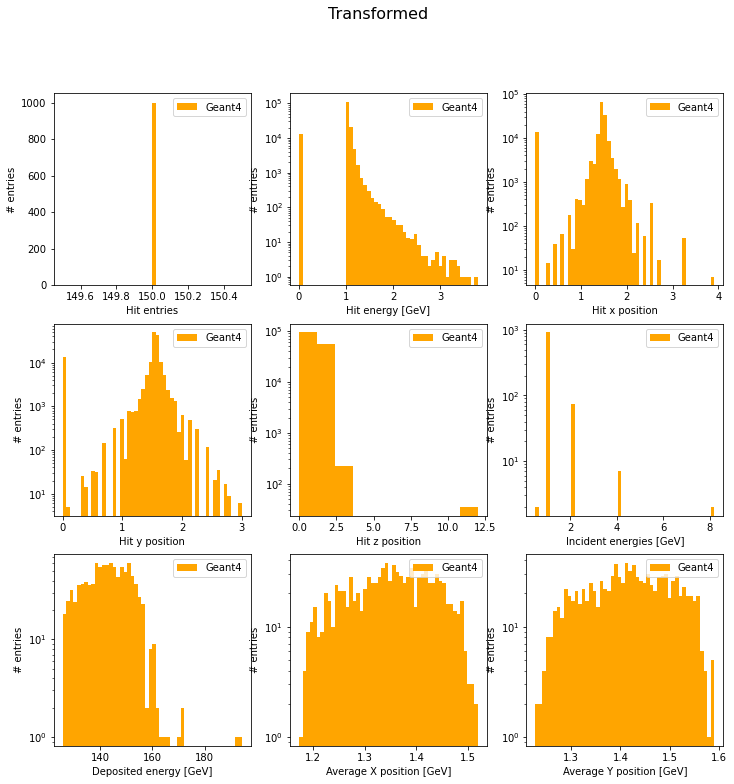

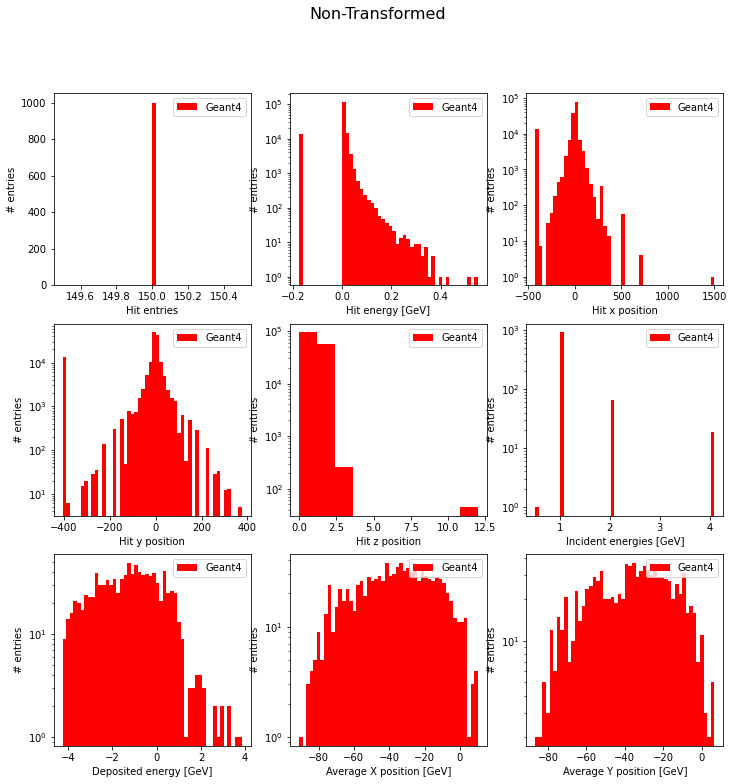

In [4]:
# Non-transformed variables
dists = util.display.plot_distribution(files_list_, energy_trans_file='transform_e.pkl', x_trans_file='transform_x.pkl', y_trans_file='transform_y.pkl', nshowers_2_plot=1000)
entries = dists[0]
all_incident_e = dists[1]
total_deposited_e_shower = dists[2]
all_e = dists[3]
all_x = dists[4]
all_y = dists[5]
all_z = dists[6]
all_hit_ine = dists[7]
average_x_shower = dists[8]
average_y_shower = dists[9]

# Transformed variables
dists_trans = util.display.plot_distribution(files_list_, nshowers_2_plot=1000)
entries = dists_trans[0]
all_incident_e_trans = dists_trans[1]
total_deposited_e_shower_trans = dists_trans[2]
all_e_trans = dists_trans[3]
all_x_trans = dists_trans[4]
all_y_trans = dists_trans[5]
all_z_trans = dists_trans[6]
all_hit_ine_trans = dists_trans[7]
average_x_shower_trans = dists_trans[8]
average_y_shower_trans = dists_trans[9]

fig, ax = plt.subplots(3,3, figsize=(12,12))
fig.suptitle('Transformed', fontsize=16)
print('Plot # entries')
ax[0][0].set_ylabel('# entries')
ax[0][0].set_xlabel('Hit entries')
ax[0][0].hist(entries, 50, color='orange', label='Geant4')
ax[0][0].legend(loc='upper right')

print('Plot hit energies')
ax[0][1].set_ylabel('# entries')
ax[0][1].set_xlabel('Hit energy [GeV]')
ax[0][1].hist(all_e_trans, 50, color='orange', label='Geant4')
ax[0][1].set_yscale('log')
ax[0][1].legend(loc='upper right')

print('Plot hit x')
ax[0][2].set_ylabel('# entries')
ax[0][2].set_xlabel('Hit x position')
ax[0][2].hist(all_x_trans, 50, color='orange', label='Geant4')
ax[0][2].set_yscale('log')
ax[0][2].legend(loc='upper right')

print('Plot hit y')
ax[1][0].set_ylabel('# entries')
ax[1][0].set_xlabel('Hit y position')
ax[1][0].hist(all_y_trans, 50, color='orange', label='Geant4')
ax[1][0].set_yscale('log')
ax[1][0].legend(loc='upper right')

print('Plot hit z')
ax[1][1].set_ylabel('# entries')
ax[1][1].set_xlabel('Hit z position')
ax[1][1].hist(all_z_trans, color='orange', label='Geant4')
ax[1][1].set_yscale('log')
ax[1][1].legend(loc='upper right')

print('Plot incident energies')
ax[1][2].set_ylabel('# entries')
ax[1][2].set_xlabel('Incident energies [GeV]')
ax[1][2].hist(all_incident_e_trans, 50, color='orange', label='Geant4')
ax[1][2].set_yscale('log')
ax[1][2].legend(loc='upper right')

print('Plot total deposited hit energy per shower')
ax[2][0].set_ylabel('# entries')
ax[2][0].set_xlabel('Deposited energy [GeV]')
ax[2][0].hist(total_deposited_e_shower_trans, 50, color='orange', label='Geant4')
ax[2][0].set_yscale('log')
ax[2][0].legend(loc='upper right')

print('Plot av. X position per shower')
ax[2][1].set_ylabel('# entries')
ax[2][1].set_xlabel('Average X position [GeV]')
ax[2][1].hist(average_x_shower_trans, 50, color='orange', label='Geant4')
ax[2][1].set_yscale('log')
ax[2][1].legend(loc='upper right')

print('Plot av. Y position per shower')
ax[2][2].set_ylabel('# entries')
ax[2][2].set_xlabel('Average Y position [GeV]')
ax[2][2].hist(average_y_shower_trans, 50, color='orange', label='Geant4')
ax[2][2].set_yscale('log')
ax[2][2].legend(loc='upper right')

fig.show()
save_name = os.path.join(dataset_store_path,'input_dists_transformed.png')
fig.savefig(save_name)

fig, ax = plt.subplots(3,3, figsize=(12,12))
fig.suptitle('Non-Transformed', fontsize=16)
print('Plot # entries')
ax[0][0].set_ylabel('# entries')
ax[0][0].set_xlabel('Hit entries')
ax[0][0].hist(entries, 50, color='red', label='Geant4')
ax[0][0].legend(loc='upper right')

print('Plot hit energies')
ax[0][1].set_ylabel('# entries')
ax[0][1].set_xlabel('Hit energy [GeV]')
ax[0][1].hist(all_e, 50, color='red', label='Geant4')
ax[0][1].set_yscale('log')
ax[0][1].legend(loc='upper right')

print('Plot hit x')
ax[0][2].set_ylabel('# entries')
ax[0][2].set_xlabel('Hit x position')
ax[0][2].hist(all_x, 50, color='red', label='Geant4')
ax[0][2].set_yscale('log')
ax[0][2].legend(loc='upper right')

print('Plot hit y')
ax[1][0].set_ylabel('# entries')
ax[1][0].set_xlabel('Hit y position')
ax[1][0].hist(all_y, 50, color='red', label='Geant4')
ax[1][0].set_yscale('log')
ax[1][0].legend(loc='upper right')

print('Plot hit z')
ax[1][1].set_ylabel('# entries')
ax[1][1].set_xlabel('Hit z position')
ax[1][1].hist(all_z, color='red', label='Geant4')
ax[1][1].set_yscale('log')
ax[1][1].legend(loc='upper right')

print('Plot incident energies')
ax[1][2].set_ylabel('# entries')
ax[1][2].set_xlabel('Incident energies [GeV]')
ax[1][2].hist(all_incident_e, 50, color='red', label='Geant4')
ax[1][2].set_yscale('log')
ax[1][2].legend(loc='upper right')

print('Plot total deposited hit energy per shower')
ax[2][0].set_ylabel('# entries')
ax[2][0].set_xlabel('Deposited energy [GeV]')
ax[2][0].hist(total_deposited_e_shower, 50, color='red', label='Geant4')
ax[2][0].set_yscale('log')
ax[2][0].legend(loc='upper right')

print('Plot av. X position per shower')
ax[2][1].set_ylabel('# entries')
ax[2][1].set_xlabel('Average X position [GeV]')
ax[2][1].hist(average_x_shower, 50, color='red', label='Geant4')
ax[2][1].set_yscale('log')
ax[2][1].legend(loc='upper right')

print('Plot av. Y position per shower')
ax[2][2].set_ylabel('# entries')
ax[2][2].set_xlabel('Average Y position [GeV]')
ax[2][2].hist(average_y_shower, 50, color='red', label='Geant4')
ax[2][2].set_yscale('log')
ax[2][2].legend(loc='upper right')

fig.show()
save_name = os.path.join(dataset_store_path,'input_dists_non_transformed.png')
fig.savefig(save_name)

## 2D distributions
Now we can look at tsome of the 2D correlation plots between features we want to generate, as well as the conditional incident energy. We can also see the 1D PDF (plotted in the cells above) along the x/y-axis. The z-axis always shows the incident energy. We compare non-transformed with transformed variables. Note that this cell depends on variables set in the cell above e.g. to change the number of showers ghenerated for the Transformed examples, you need to change the number of showers to plot in the cell above and re-run.

save_name: X_HitenergyGeV.png
save_name: IncidentenergyGeV_HitenergyGeV.png
save_name: entries_Av.EnergyDepositedGeV.png
save_name: Av.XPosition_Av.EnergyDepositedGeV.png
save_name: Av.XPosition_Av.YPosition.png
save_name: IncidentenergyGeV_Av.EnergyDepositedGeV.png


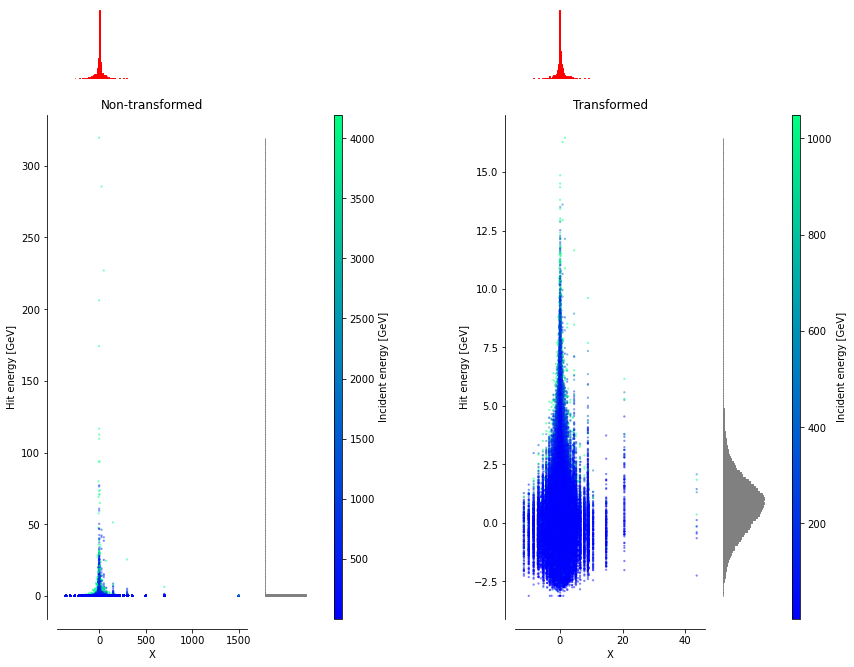

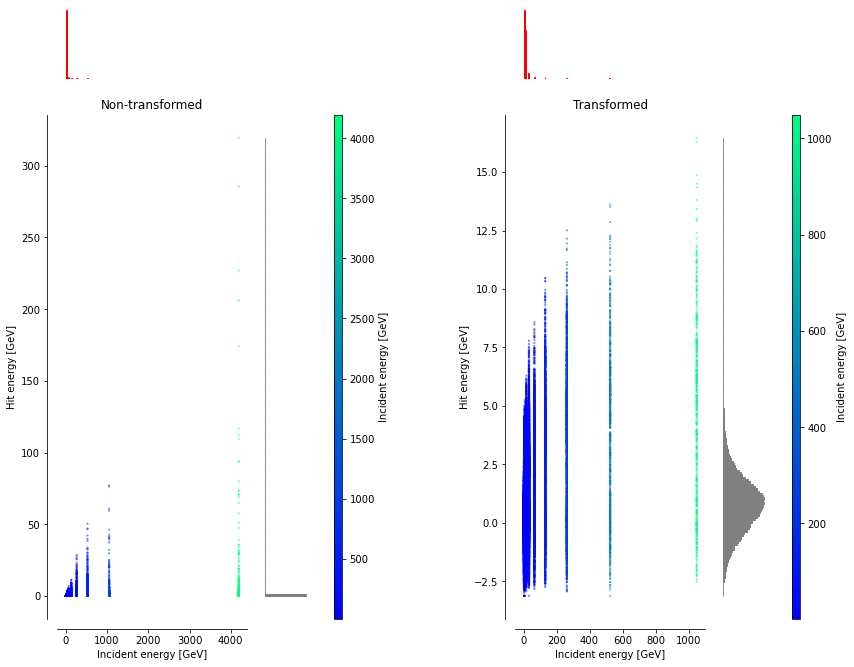

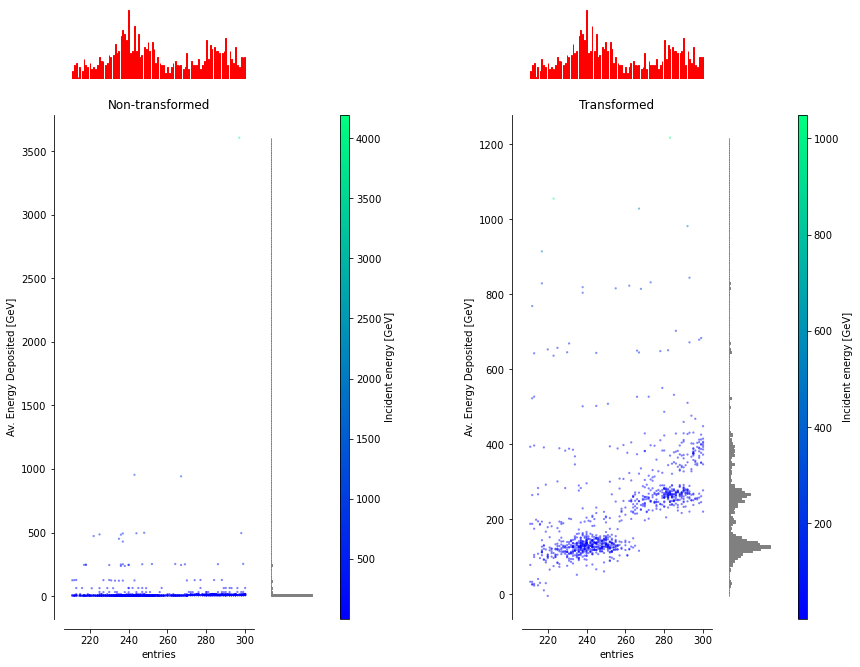

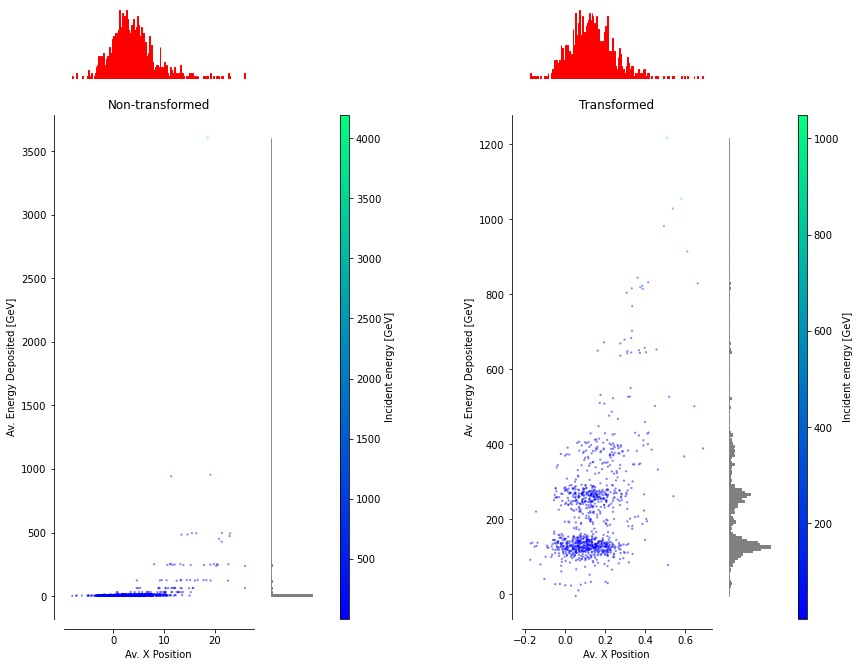

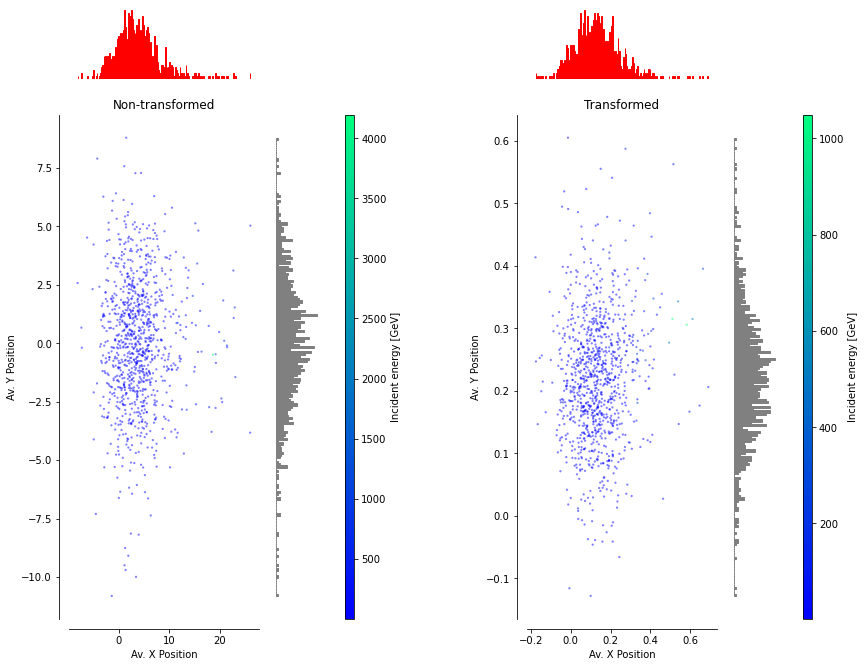

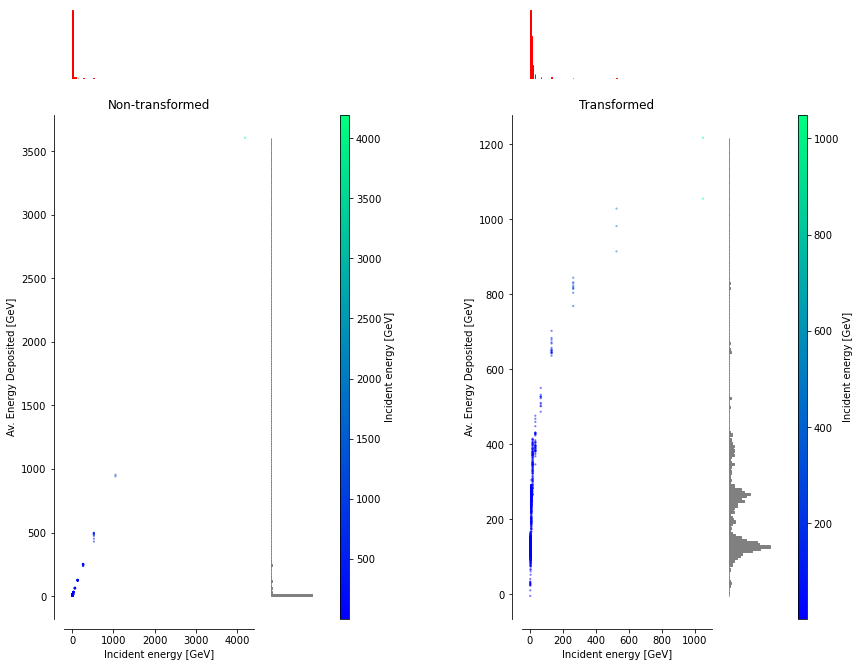

In [11]:
# Non-transformed variables
'''dists = util.display.plot_distribution(files_list_, nshowers_2_plot=1000, energy_trans_file='transform_e.pkl', x_trans_file='transform_x.pkl', y_trans_file='transform_y.pkl')
entries = dists[0]
all_incident_e = dists[1]
total_deposited_e_shower = dists[2]
all_e = dists[3]
all_x = dists[4]
all_y = dists[5]
all_z = dists[6]
all_hit_ine = dists[7]
average_x_shower = dists[8]
average_y_shower = dists[9]'''

distributions = [(('X', 'Hit energy [GeV]', 'Incident energy [GeV]') , (all_x, all_e, all_hit_ine, all_x_trans, all_e_trans, all_hit_ine_trans))]
util.display.make_plot(distributions)

distributions = [(('Hit energy [GeV]', 'Incident energy [GeV]', 'Incident energy [GeV]') , (all_e, all_hit_ine, all_hit_ine, all_e_trans, all_hit_ine_trans, all_hit_ine_trans))]
util.display.make_plot(distributions)

distributions = [(('entries', 'Av. Energy Deposited [GeV]', 'Incident energy [GeV]') , (entries, total_deposited_e_shower, all_incident_e, entries, total_deposited_e_shower_trans, all_incident_e_trans))]
util.display.make_plot(distributions)

distributions = [(('Av. X Position', 'Av. Energy Deposited [GeV]', 'Incident energy [GeV]') , (average_x_shower, total_deposited_e_shower, all_incident_e, average_x_shower_trans, total_deposited_e_shower_trans, all_incident_e_trans))]
util.display.make_plot(distributions)

distributions = [(('Av. X Position', 'Av. Y Position', 'Incident energy [GeV]') , (average_x_shower, average_y_shower, all_incident_e, average_x_shower_trans, average_y_shower_trans, all_incident_e_trans))]
util.display.make_plot(distributions)

distributions = [(('Incident energy [GeV]', 'Av. Energy Deposited [GeV]', 'Incident energy [GeV]') , (all_incident_e, total_deposited_e_shower, all_incident_e, all_incident_e_trans, total_deposited_e_shower_trans, all_incident_e_trans))]
util.display.make_plot(distributions)


## Adding noise via SDE's
We can now demonstrate how a few of the input features will be changed via the noising procedures. We perturb the data according to the standard deviation of the distribution defined by the SDE. If the std is large enough, we are able to populate less dense regions of data / less populated regions of the PDF. Play around with varying size coefficients used in the SDE beneath to see how they affect the std of the SDE and subsequently its ability to populate low density regions.

### Variation Preserving SDE
Data will be perturbed according to the SDE defined in utils.py. Note that even when t==0, though the 'mean' of the data will return the same data as before (multiplied by unity), we still add noise to it, thus smearing the input data a little. This SDE progressively smears and moves the mean of the data.

output_dir: example_VP_SDE_0.1_50.0
/eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry211To240.pt
Loading 112 batches
Batch: 0
Batch: 20
Batch: 40
Batch: 60
Batch: 80
Batch: 100
/eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry241To270.pt
Loading 217 batches
Batch: 0
Batch: 20
Batch: 40
Batch: 60
Batch: 80
Batch: 100
Batch: 120
Batch: 140
Batch: 160
Batch: 180
Batch: 200
/eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry271To300.pt
Loading 275 batches
Batch: 0
Batch: 20
Batch: 40
Batch: 60
Batch: 80
Batch: 100
Batch: 120
Batch: 140
Batch: 160
Batch: 180
Batch: 200
Batch: 220
Batch: 240
Batch: 260
save_name: Showerindividualhitenergy_perurbation_1D.png
save_name: Showerindividualhitx_perurbation_1D.png
save_name: Showerindividualhity_perurbation_1D.png


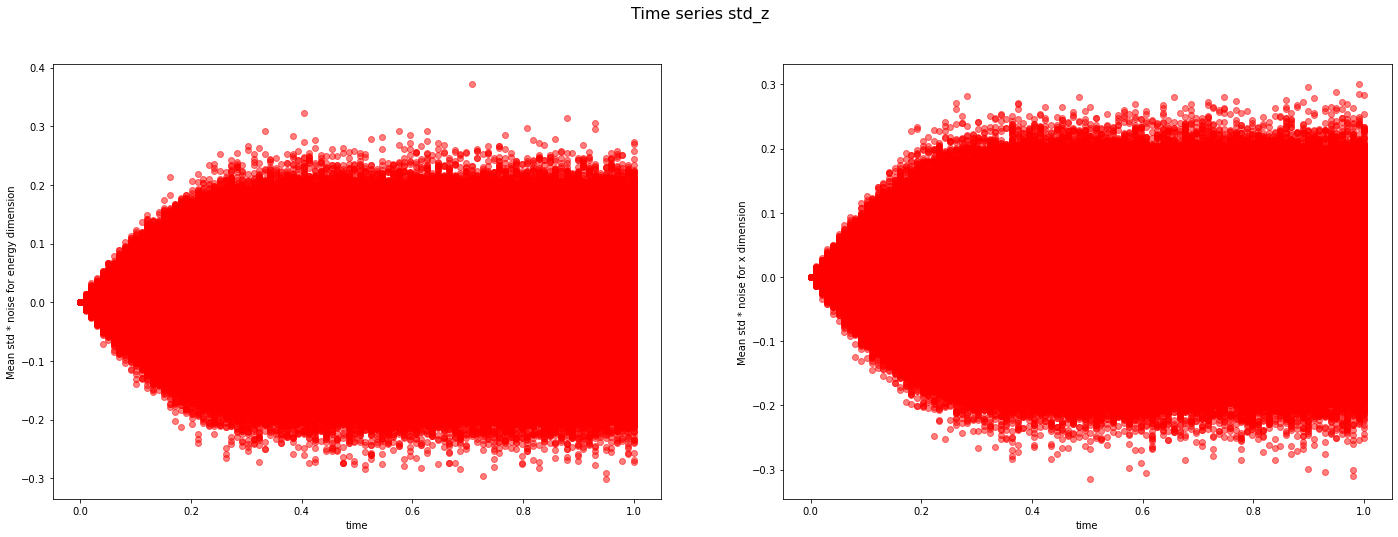

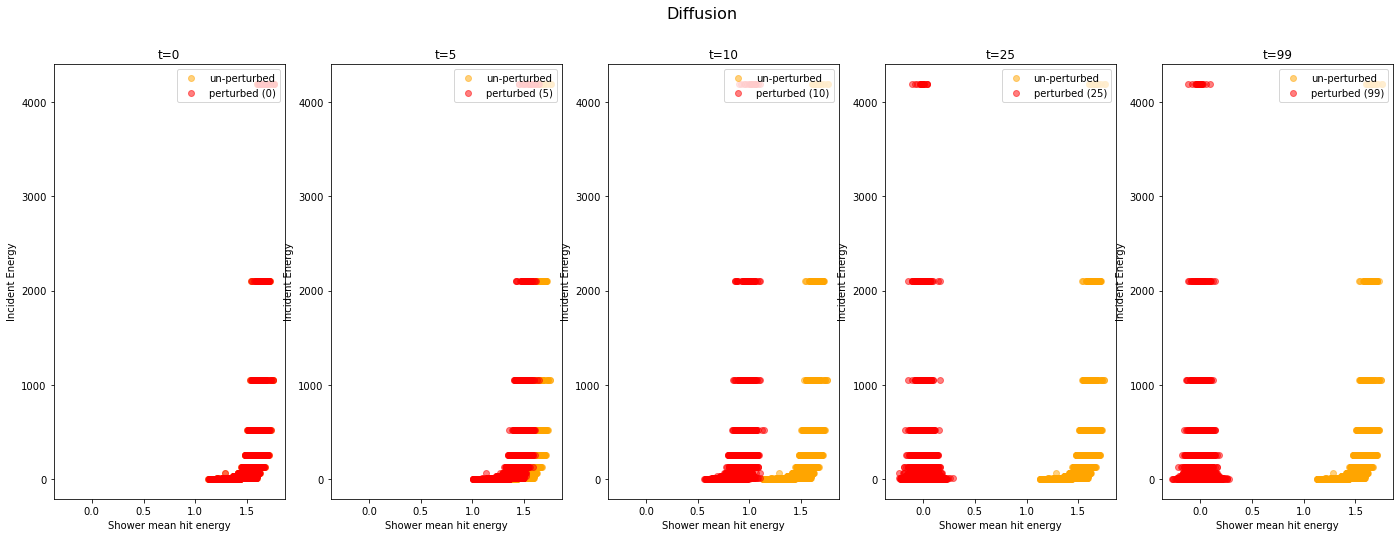

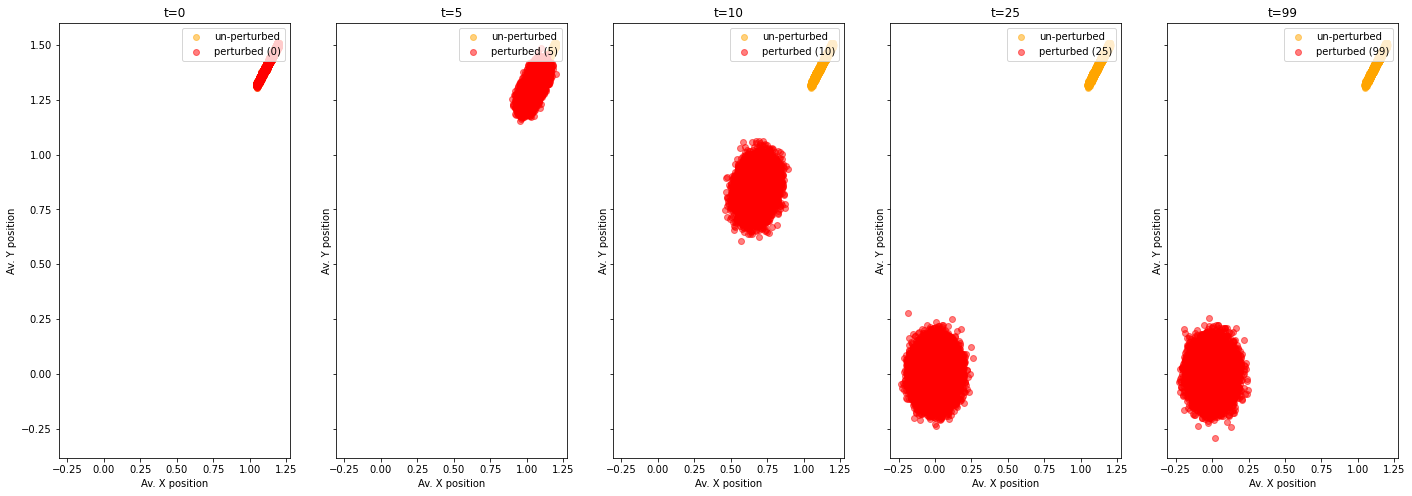

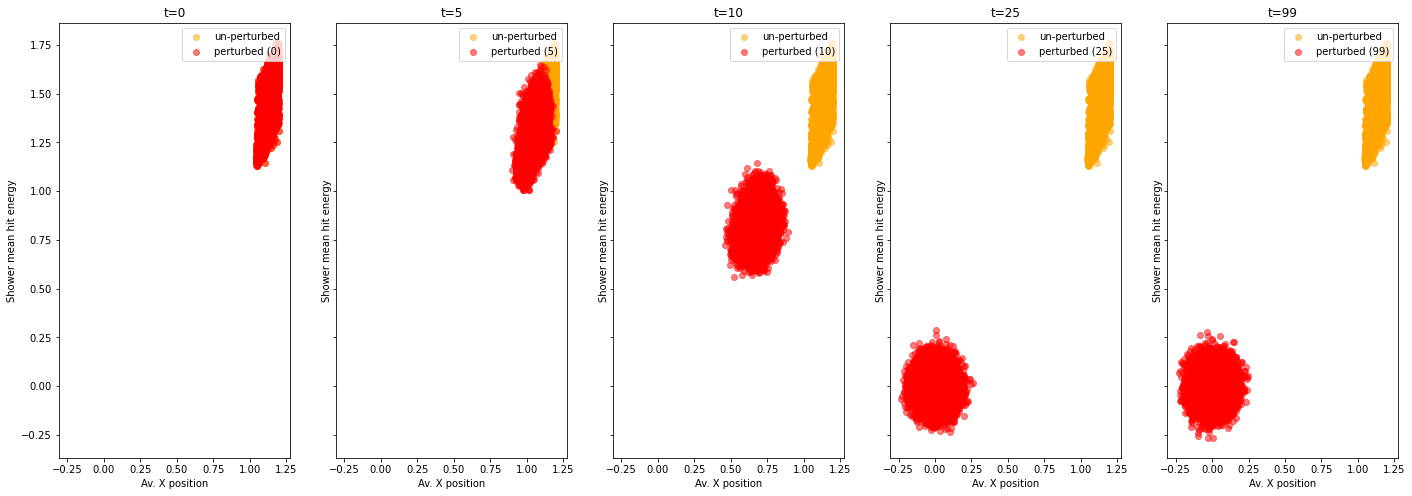

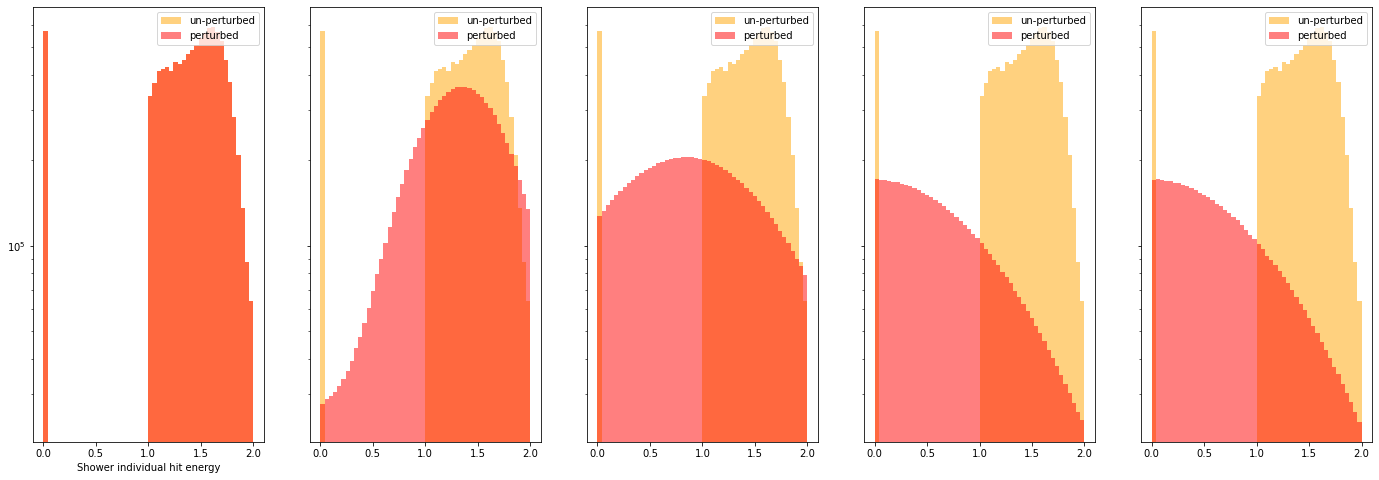

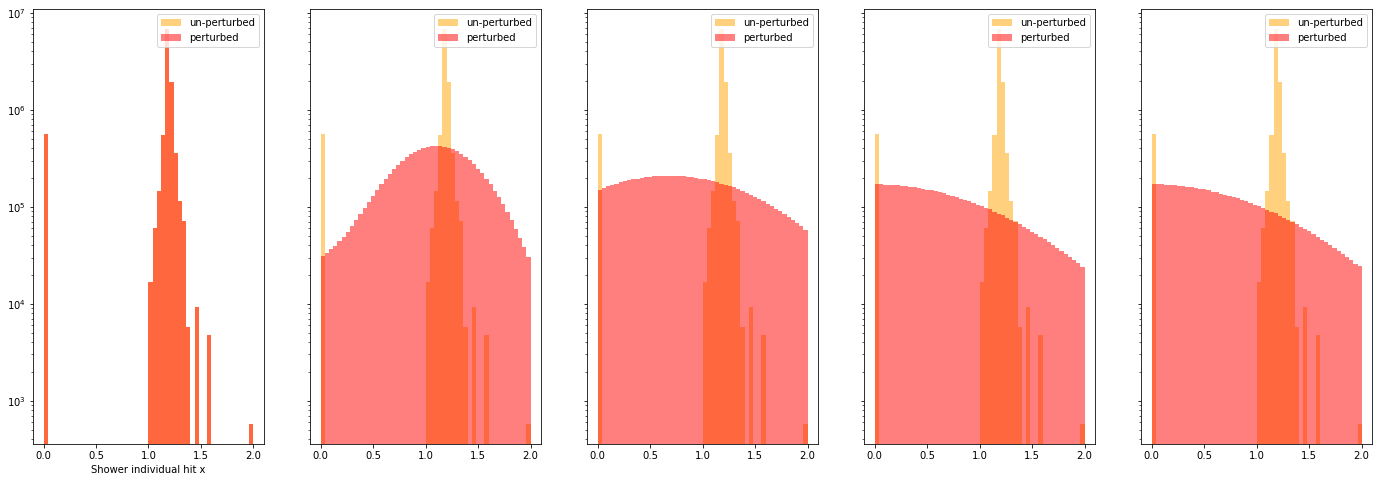

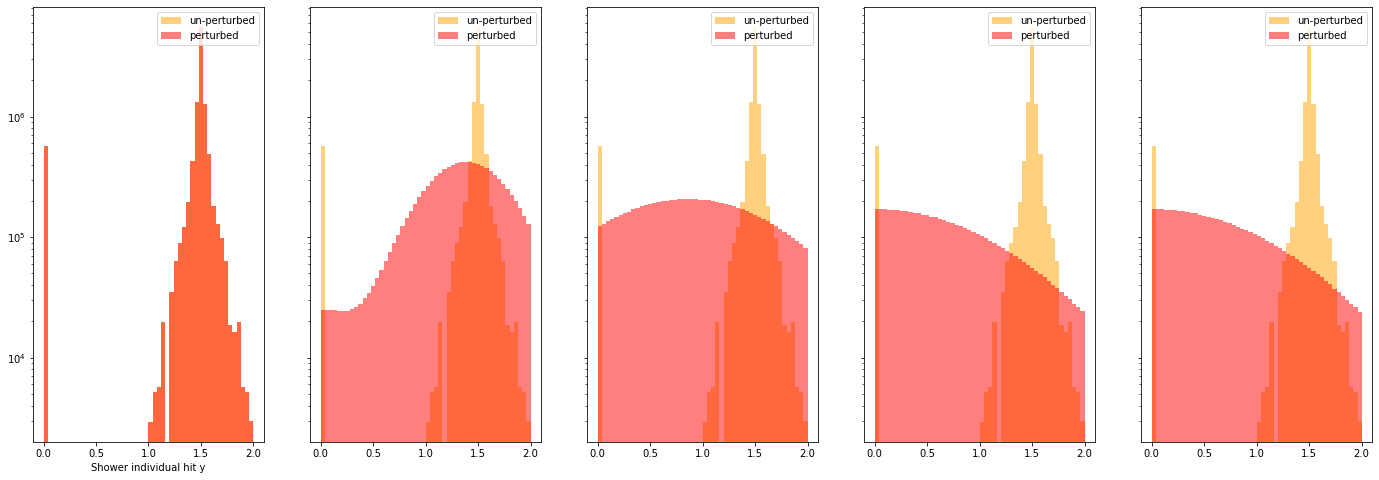

In [9]:
if SDE == 'VP':
    output_dir = 'example_'+SDE+'_SDE_'+str(beta_min)+'_'+str(beta_max)
if SDE == 'VE':
    output_dir = 'example_'+SDE+'_SDE_'+str(sigma_min)+'_'+str(sigma_max)
    
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f'output_dir: {output_dir}')

all_incident_e = []

original_hite = []
p0_hite = []
p1_hite = []
p2_hite = []
p3_hite = []
p4_hite = []

original_hitx = []
p0_hitx = []
p1_hitx = []
p2_hitx = []
p3_hitx = []
p4_hitx = []

original_hity = []
p0_hity = []
p1_hity = []
p2_hity = []
p3_hity = []
p4_hity = []

original_mean_hit_energy = []
p0_mean_hit_energy = []
p1_mean_hit_energy = []
p2_mean_hit_energy = []
p3_mean_hit_energy = []
p4_mean_hit_energy = []

original_av_x = []
p0_av_x = []
p1_av_x = []
p2_av_x = []
p3_av_x = []
p4_av_x = []

original_av_y = []
p0_av_y = []
p1_av_y = []
p2_av_y = []
p3_av_y = []
p4_av_y = []

mean_valid_e_std_z_ = []
mean_valid_x_std_z_ = []
mean_valid_y_std_z_ = []
batch_time_steps_ = []
time_steps = np.linspace(0., 1., 100)

steps_to_draw = [0, 5, 10, 25, 99]
    
for filename in files_list_:
    print(filename)
    custom_data = utils.cloud_dataset(filename, device=device)
    train_size = int(train_ratio * len(custom_data.data))
    test_size = len(custom_data.data) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(custom_data, [train_size, test_size])
    shower_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    print(f'Loading {len(shower_loader_train)} batches')
    
    for i, (shower_data,incident_energies) in enumerate(shower_loader_train,0):
        if i % 20 == 0:
            print(f'Batch: {i}')
        
        # copy tensors to numpy arrays for plotting purposes
        original_data = shower_data.cpu().numpy().copy()
        incident_energies = incident_energies.cpu().numpy().copy()
        
        # Generate padding mask for padded entries
        # Inverse mask to ignore for when 0-padded hits should be ignored
        output_mask = (shower_data[:,:,0]!= padding_value).type(torch.int)
        output_mask = output_mask.unsqueeze(-1)
        output_mask = output_mask.expand(output_mask.size()[0], output_mask.size()[1],4)
        mask = ~(shower_data[:,:,0] == padding_value)
        mask = mask.cpu().numpy().copy()
        diffusion_step_=0
        for time_step in time_steps:
            #if diffusion_step_%10 == 0 and i == 0:
            #    print(f'diffusion_step_: {diffusion_step_} time: {time_step}')
            
            if type(shower_data).__module__ == np.__name__:
                shower_data = torch.from_numpy(shower_data).to(device)
                
            batch_time_step = torch.ones(incident_energies.shape[0], device=device) * time_step

            # Noise input
            z = torch.normal(0,1,size=shower_data.shape, device=device)
            z = z.to(device)
            
            # Sample from standard deviation of noise
            mean_, std_ = marginal_prob_std_fn(shower_data,batch_time_step)

            # Add noise to input
            std_z_ = std_[:, None, None]*z
            shower_data = mean_ + std_z_
            shower_data = shower_data.cpu().numpy().copy()

            # One shower at a time
            for j in range(0,len(shower_data)):
                # Original data
                original_valid = original_data[j]#[mask[j]]
                mean_original_e = np.mean(original_valid[:,0])
                av_original_x = np.mean(original_valid[:,1])
                av_original_y = np.mean(original_valid[:,2])
                # Data perturbed by SDE
                valid_hits = shower_data[j]#[mask[j]]
                mean_hit_e_ = np.mean(valid_hits[:,0])
                av_hit_x_ = np.mean(valid_hits[:,1])
                av_hit_y_ = np.mean(valid_hits[:,2])
                
                valid_std_z_ = std_z_[j][mask[j]]
                mean_valid_e_std_z_.append(torch.mean(valid_std_z_[:,0]).cpu().item())
                mean_valid_x_std_z_.append(torch.mean(valid_std_z_[:,1]).cpu().item())
                mean_valid_y_std_z_.append(torch.mean(valid_std_z_[:,2]).cpu().item())
                batch_time_steps_.append(time_step)

                if diffusion_step_ == steps_to_draw[0]:
                    all_incident_e.append(incident_energies[j])
                    original_hite.extend(original_valid[:,0])
                    original_hitx.extend(original_valid[:,1])
                    original_hity.extend(original_valid[:,2])
                    original_mean_hit_energy.append(mean_original_e)
                    original_av_x.append(av_original_x)
                    original_av_y.append(av_original_y)
                    p0_hite.extend(valid_hits[:,0])
                    p0_hitx.extend(valid_hits[:,1])
                    p0_hity.extend(valid_hits[:,2])
                    p0_mean_hit_energy.append(mean_hit_e_)
                    p0_av_x.append(av_hit_x_)
                    p0_av_y.append(av_hit_y_)
                if diffusion_step_ == steps_to_draw[1]:
                    p1_hite.extend(valid_hits[:,0])
                    p1_hitx.extend(valid_hits[:,1])
                    p1_hity.extend(valid_hits[:,2])
                    p1_mean_hit_energy.append(mean_hit_e_)
                    p1_av_x.append(av_hit_x_)
                    p1_av_y.append(av_hit_y_)
                if diffusion_step_ == steps_to_draw[2]:
                    p2_hite.extend(valid_hits[:,0])
                    p2_hitx.extend(valid_hits[:,1])
                    p2_hity.extend(valid_hits[:,2])
                    p2_mean_hit_energy.append(mean_hit_e_)
                    p2_av_x.append(av_hit_x_)
                    p2_av_y.append(av_hit_y_)
                if diffusion_step_ == steps_to_draw[3]:
                    p3_hite.extend(valid_hits[:,0])
                    p3_hitx.extend(valid_hits[:,1])
                    p3_hity.extend(valid_hits[:,2])
                    p3_mean_hit_energy.append(mean_hit_e_)
                    p3_av_x.append(av_hit_x_)
                    p3_av_y.append(av_hit_y_)
                if diffusion_step_ == steps_to_draw[4]:
                    p4_hite.extend(valid_hits[:,0])
                    p4_hitx.extend(valid_hits[:,1])
                    p4_hity.extend(valid_hits[:,2])
                    p4_mean_hit_energy.append(mean_hit_e_)
                    p4_av_x.append(av_hit_x_)
                    p4_av_y.append(av_hit_y_)

            diffusion_step_+=1
            
fig, axs = plt.subplots(1,2, figsize=(24,8), sharex=True)
fig.suptitle('Time series std_z', fontsize=16)
axs[0].set_ylabel('Mean std * noise for energy dimension')
axs[0].set_xlabel('time')
axs[0].scatter(batch_time_steps_, mean_valid_e_std_z_, alpha=0.5, color='red', label='')

axs[1].set_ylabel('Mean std * noise for x dimension')
axs[1].set_xlabel('time')
axs[1].scatter(batch_time_steps_, mean_valid_x_std_z_, alpha=0.5, color='red', label='')

save_name = os.path.join(output_dir,'Mean std * noise.png')
fig.savefig(save_name)
                
fig, axs = plt.subplots(1,5, figsize=(24,8), sharex=True)
fig.suptitle('Diffusion', fontsize=16)

title_1 = 't='+str(steps_to_draw[0])
label_1 = 'perturbed ('+str(steps_to_draw[0])+')'
axs[0].set_title(title_1)
axs[0].set_ylabel('Incident Energy')
axs[0].set_xlabel('Shower mean hit energy')
axs[0].scatter(original_mean_hit_energy, all_incident_e, alpha=0.5, color='orange', label='un-perturbed')
axs[0].scatter(p0_mean_hit_energy, all_incident_e, alpha=0.5, color='red', label=label_1)
axs[0].legend(loc='upper right')

title_2 = 't='+str(steps_to_draw[1])
label_2 = 'perturbed ('+str(steps_to_draw[1])+')'
axs[1].set_title(title_2)
axs[1].set_ylabel('Incident Energy')
axs[1].set_xlabel('Shower mean hit energy')
axs[1].scatter(original_mean_hit_energy, all_incident_e, alpha=0.5, color='orange', label='un-perturbed')
axs[1].scatter(p1_mean_hit_energy, all_incident_e, alpha=0.5, color='red', label=label_2)
axs[1].legend(loc='upper right')

title_3 = 't='+str(steps_to_draw[2])
label_3 = 'perturbed ('+str(steps_to_draw[2])+')'
axs[2].set_title(title_3)
axs[2].set_ylabel('Incident Energy')
axs[2].set_xlabel('Shower mean hit energy')
axs[2].scatter(original_mean_hit_energy, all_incident_e, alpha=0.5, color='orange', label='un-perturbed')
axs[2].scatter(p2_mean_hit_energy, all_incident_e, alpha=0.5, color='red', label=label_3)
axs[2].legend(loc='upper right')

title_4 = 't='+str(steps_to_draw[3])
label_4 = 'perturbed ('+str(steps_to_draw[3])+')'
axs[3].set_title(title_4)
axs[3].set_ylabel('Incident Energy')
axs[3].set_xlabel('Shower mean hit energy')
axs[3].scatter(original_mean_hit_energy, all_incident_e, alpha=0.5, color='orange', label='un-perturbed')
axs[3].scatter(p3_mean_hit_energy, all_incident_e, alpha=0.5, color='red', label=label_4)
axs[3].legend(loc='upper right')

title_5 = 't='+str(steps_to_draw[4])
label_5 = 'perturbed ('+str(steps_to_draw[4])+')'
axs[4].set_title(title_5)
axs[4].set_ylabel('Incident Energy')
axs[4].set_xlabel('Shower mean hit energy')
axs[4].scatter(original_mean_hit_energy, all_incident_e, alpha=0.5, color='orange', label='un-perturbed')
axs[4].scatter(p4_mean_hit_energy, all_incident_e, alpha=0.5, color='red', label=label_5)
axs[4].legend(loc='upper right')

save_name = os.path.join(output_dir,'mean_hit_e_vs_ine.png')
fig.savefig(save_name)

fig, axs_1 = plt.subplots(1,5, figsize=(24,8), sharex=True, sharey=True)
axs_1[0].set_title(title_1)
axs_1[0].set_ylabel('Av. Y position')
axs_1[0].set_xlabel('Av. X position')
axs_1[0].scatter(original_av_x, original_av_y, alpha=0.5, color='orange', label='un-perturbed')
axs_1[0].scatter(p0_av_x, p0_av_y, alpha=0.5, color='red', label=label_1)
axs_1[0].legend(loc='upper right')

axs_1[1].set_title(title_2)
axs_1[1].set_ylabel('Av. Y position')
axs_1[1].set_xlabel('Av. X position')
axs_1[1].scatter(original_av_x, original_av_y, alpha=0.5, color='orange', label='un-perturbed')
axs_1[1].scatter(p1_av_x, p1_av_y, alpha=0.5, color='red', label=label_2)
axs_1[1].legend(loc='upper right')

axs_1[2].set_title(title_3)
axs_1[2].set_ylabel('Av. Y position')
axs_1[2].set_xlabel('Av. X position')
axs_1[2].scatter(original_av_x, original_av_y, alpha=0.5, color='orange', label='un-perturbed')
axs_1[2].scatter(p2_av_x, p2_av_y, alpha=0.5, color='red', label=label_3)
axs_1[2].legend(loc='upper right')

axs_1[3].set_title(title_4)
axs_1[3].set_ylabel('Av. Y position')
axs_1[3].set_xlabel('Av. X position')
axs_1[3].scatter(original_av_x, original_av_y, alpha=0.5, color='orange', label='un-perturbed')
axs_1[3].scatter(p3_av_x, p3_av_y, alpha=0.5, color='red', label=label_4)
axs_1[3].legend(loc='upper right')

axs_1[4].set_title(title_5)
axs_1[4].set_ylabel('Av. Y position')
axs_1[4].set_xlabel('Av. X position')
axs_1[4].scatter(original_av_x, original_av_y, alpha=0.5, color='orange', label='un-perturbed')
axs_1[4].scatter(p4_av_x, p4_av_y, alpha=0.5, color='red', label=label_5)
axs_1[4].legend(loc='upper right')

save_name = os.path.join(output_dir,'mean_hit_x_vs_y.png')
fig.savefig(save_name)

fig, axs_2 = plt.subplots(1,5, figsize=(24,8), sharex=True, sharey=True)
axs_2[0].set_title(title_1)
axs_2[0].set_ylabel('Shower mean hit energy')
axs_2[0].set_xlabel('Av. X position')
axs_2[0].scatter(original_av_x, original_mean_hit_energy, alpha=0.5, color='orange', label='un-perturbed')
axs_2[0].scatter(p0_av_x, p0_mean_hit_energy, alpha=0.5, color='red', label=label_1)
axs_2[0].legend(loc='upper right')

axs_2[1].set_title(title_2)
axs_2[1].set_ylabel('Shower mean hit energy')
axs_2[1].set_xlabel('Av. X position')
axs_2[1].scatter(original_av_x, original_mean_hit_energy, alpha=0.5, color='orange', label='un-perturbed')
axs_2[1].scatter(p1_av_x, p1_mean_hit_energy, alpha=0.5, color='red', label=label_2)
axs_2[1].legend(loc='upper right')

axs_2[2].set_title(title_3)
axs_2[2].set_ylabel('Shower mean hit energy')
axs_2[2].set_xlabel('Av. X position')
axs_2[2].scatter(original_av_x, original_mean_hit_energy, alpha=0.5, color='orange', label='un-perturbed')
axs_2[2].scatter(p2_av_x, p2_mean_hit_energy, alpha=0.5, color='red', label=label_3)
axs_2[2].legend(loc='upper right')

axs_2[3].set_title(title_4)
axs_2[3].set_ylabel('Shower mean hit energy')
axs_2[3].set_xlabel('Av. X position')
axs_2[3].scatter(original_av_x, original_mean_hit_energy, alpha=0.5, color='orange', label='un-perturbed')
axs_2[3].scatter(p3_av_x, p3_mean_hit_energy, alpha=0.5, color='red', label=label_4)
axs_2[3].legend(loc='upper right')

axs_2[4].set_title(title_5)
axs_2[4].set_ylabel('Shower mean hit energy')
axs_2[4].set_xlabel('Av. X position')
axs_2[4].scatter(original_av_x, original_mean_hit_energy, alpha=0.5, color='orange', label='un-perturbed')
axs_2[4].scatter(p4_av_x, p4_mean_hit_energy, alpha=0.5, color='red', label=label_5)
axs_2[4].legend(loc='upper right')

save_name = os.path.join(output_dir,'mean_hit_x_vs_e.png')
fig.savefig(save_name)

distributions = [(('Shower individual hit energy') , (original_hite, p0_hite, p1_hite, p2_hite, p3_hite, p4_hite))]
util.display.perturbation_1D(distributions, output_dir)

distributions = [(('Shower individual hit x') , (original_hitx, p0_hitx, p1_hitx, p2_hitx, p3_hitx, p4_hitx))]
util.display.perturbation_1D(distributions, output_dir)

distributions = [(('Shower individual hit y') , (original_hity, p0_hity, p1_hity, p2_hity, p3_hity, p4_hity))]
util.display.perturbation_1D(distributions, output_dir)

## Training

Training is performed now on the transformed input features, therefore the generated samples will also be in the transformed feature space. This cell will training call methods from the trans_tdsm.py script so everything should be synchronised with what we can run on condor for the big jobs.

  0%|          | 0/100 [00:00<?, ?it/s]

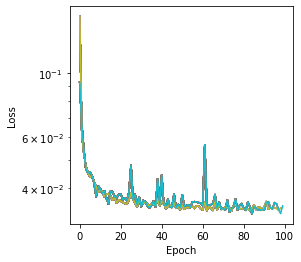

['/eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry211To240.pt', '/eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry241To270.pt', '/eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry271To300.pt']


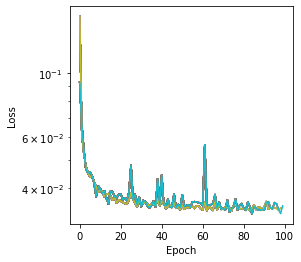

In [3]:
output_directory = workingdir+'/training_'+datetime.now().strftime('%Y%m%d_%H%M')+'_output/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
optimiser = RAdam(model.parameters(),lr=lr)
av_training_losses_per_epoch = []
av_testing_losses_per_epoch = []

fig, ax = plt.subplots(ncols=1, figsize=(4,4))
epochs = tqdm.notebook.trange(n_epochs)
dh = display.display(fig, display_id=True)
ax.set_title('')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_yscale('log')

print(files_list_)

for epoch in epochs:

    # Create/clear per epoch variables
    cumulative_epoch_loss = 0.
    cumulative_test_epoch_loss = 0.

    file_counter = 0
    n_training_showers = 0
    n_testing_showers = 0
    training_batches_per_epoch = 0
    testing_batches_per_epoch = 0

    # Load files
    for filename in files_list_:
        custom_data = utils.cloud_dataset(filename, device=device)
        train_size = int(train_ratio * len(custom_data.data))
        test_size = len(custom_data.data) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(custom_data, [train_size, test_size])

        n_training_showers+=train_size
        n_testing_showers+=test_size
        # Load clouds for each epoch of data dataloaders length will be the number of batches
        shower_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        shower_loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        
        # Accumuate number of batches per epoch
        training_batches_per_epoch += len(shower_loader_train)
        testing_batches_per_epoch += len(shower_loader_test)
        
        # Load shower batch for training
        for i, (shower_data,incident_energies) in enumerate(shower_loader_train,0):
            # Move model to device and set dtype as same as data (note torch.double works on both CPU and GPU)
            model.to(device, shower_data.dtype)
            model.train()
            shower_data = shower_data.to(device)
            incident_energies = incident_energies.to(device)
            
            if len(shower_data) < 1:
                print('Very few hits in shower: ', len(shower_data))
                continue
            # Zero any gradients from previous steps
            optimiser.zero_grad()
            # Loss average for each batch
            loss = trans_tdsm.loss_fn(model, shower_data, incident_energies, marginal_prob_std_fn, padding_value, device=device)
            # Accumulate batch loss per epoch
            cumulative_epoch_loss+=float(loss)
            # collect dL/dx for any parameters (x) which have requires_grad = True via: x.grad += dL/dx
            loss.backward()
            # Update value of x += -lr * x.grad
            optimiser.step()
            
        # Testing on subset of file
        for i, (shower_data,incident_energies) in enumerate(shower_loader_test,0):
            with torch.no_grad():
                model.eval()
                shower_data = shower_data.to(device)
                incident_energies = incident_energies.to(device)
                test_loss = trans_tdsm.loss_fn(model, shower_data, incident_energies, marginal_prob_std_fn, padding_value, device=device)
                cumulative_test_epoch_loss+=float(test_loss)
    
    # Calculate average loss per epoch
    av_training_losses_per_epoch.append(cumulative_epoch_loss/training_batches_per_epoch)
    av_testing_losses_per_epoch.append(cumulative_test_epoch_loss/testing_batches_per_epoch)
    epochs.set_description('Average Loss: {:5f}(Train) {:5f}(Test)'.format(cumulative_epoch_loss/training_batches_per_epoch, cumulative_test_epoch_loss/testing_batches_per_epoch))
    
    ax.plot(av_training_losses_per_epoch, label='training')
    ax.plot(av_testing_losses_per_epoch, label='testing')
    dh.update(fig)
    if epoch == n_epochs//5:
        torch.save(model.state_dict(), output_directory+'ckpt_tmp_'+str(epoch)+'.pth')
fig.savefig(output_directory+'loss_v_epoch.png')
torch.save(model.state_dict(), output_directory+'ckpt_tmp_'+str(epoch)+'.pth')


## Sampling
We now perform the generation. You need to set the loaded file name as the model trained in the previous cell. The sampling methods from trans_tdsm.py are again used for the sampling. This cell will also provide the inputs needed for plots at various stages of the diffusion. If you want plots in the non-transformed space, you need to add include the names for the transformer pickle files.

batch_size: 64
Files: ['/eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry121To150.pt', '/eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry151To180.pt', '/eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry181To210.pt', '/eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry1To30.pt']
# showers per file: [25, 25, 25, 25]
file: /eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry121To150.pt
energy_np[j]: 1.0240000486373901
all_ine[0]: 1.0240000486373901
energy_np[j]: 1.0240000486373901
all_ine[0]: 1.0240000486373901
energy_np[j]: 1.0240000486373901
all_ine[0]: 1.0240000486373901
energy_np[j]: 1.0240000486373901
all_ine[0]: 1.0240000486373901
energy_np[j]: 1.0240000486373901
all_ine[0]: 1.0240000486373901
energy_np[j]: 1.0240000486373901
all_ine[0]: 1.0240000486373901
energy_np[j]: 1.0240000486373901
all_ine[0]: 1.0240000486373901
energy_np[j]

/eos/home-i01/j/jthomasw/tdsm_encoder/trans_tdsm.py:568: RuntimeWarning:

invalid value encountered in true_divide



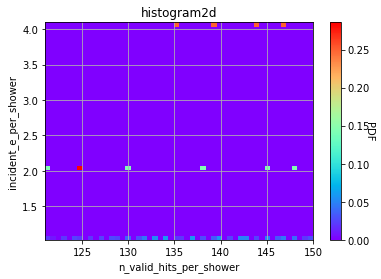

# batches: 2
Batch: 0
Generation batch 0: showers per batch: 64, max. hits per shower: 150, features per hit: 4, sampled_energies: 64
Progress: 1/2

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([64, 150, 4])
Batch: 1
Generation batch 1: showers per batch: 36, max. hits per shower: 150, features per hit: 4, sampled_energies: 36
Progress: 2/2

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([100, 150, 4])
file: /eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry151To180.pt
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 8.192000389099121
all_ine[0]: 8.192000389099121
energy_np[j]: 8.192000389099121
all_ine[0]: 8.192000389099121
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 4.0960001945495605
all_ine[0]: 4.0960001945495605
energy_np[j]: 4.0960001945495605
all_ine[0]: 4.0960001945495605
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 1.0240000486373901
all_in

/eos/home-i01/j/jthomasw/tdsm_encoder/trans_tdsm.py:568: RuntimeWarning:

invalid value encountered in true_divide



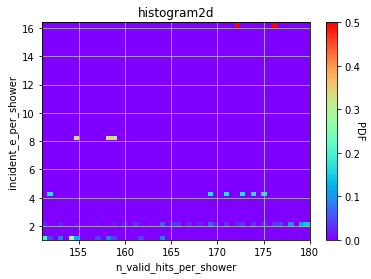

# batches: 2
Batch: 0
Generation batch 0: showers per batch: 64, max. hits per shower: 180, features per hit: 4, sampled_energies: 64
Progress: 1/2

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([64, 180, 4])
Batch: 1
Generation batch 1: showers per batch: 36, max. hits per shower: 180, features per hit: 4, sampled_energies: 36
Progress: 2/2

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([100, 180, 4])
file: /eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry181To210.pt
energy_np[j]: 4.0960001945495605
all_ine[0]: 4.0960001945495605
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 4.0960001945495605
all_ine[0]: 4.0960001945495605
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 65.53600311279297
all_ine[0]: 65.53600311279297
energy_np[j]: 8.192000389099121
all_ine[0]: 8.192000389099121
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 2.0480000972747803
all_ine[0]: 2.0480000972747803
energy_np[j]: 2.0480000972747803
all_in

/eos/home-i01/j/jthomasw/tdsm_encoder/trans_tdsm.py:568: RuntimeWarning:

invalid value encountered in true_divide



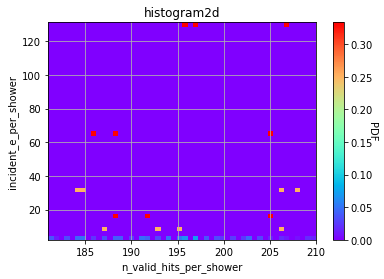

# batches: 2
Batch: 0
Generation batch 0: showers per batch: 64, max. hits per shower: 210, features per hit: 4, sampled_energies: 64
Progress: 1/2

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([64, 210, 4])
Batch: 1
Generation batch 1: showers per batch: 36, max. hits per shower: 210, features per hit: 4, sampled_energies: 36
Progress: 2/2

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([100, 210, 4])
file: /eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry1To30.pt
energy_np[j]: 0.25600001215934753
all_ine[0]: 0.25600001215934753
energy_np[j]: 0.25600001215934753
all_ine[0]: 0.25600001215934753
energy_np[j]: 0.25600001215934753
all_ine[0]: 0.25600001215934753
energy_np[j]: 0.25600001215934753
all_ine[0]: 0.25600001215934753
energy_np[j]: 0.5120000243186951
all_ine[0]: 0.5120000243186951
energy_np[j]: 0.25600001215934753
all_ine[0]: 0.25600001215934753
energy_np[j]: 0.25600001215934753
all_ine[0]: 0.25600001215934753
energy_np[j]: 0.25600001215934753
all_ine[0]: 0.25600001215934753
energy_np[j]: 0.5120000243186951
all_ine[0]: 0.5120000243186951
energy_np[j]: 0.5120000243186951
all_ine[0]: 0.5120000243186951
energy_np[j]: 0.25600001215934753
all_ine[0]: 0.25600001215934753
energy_np[j]: 0.25600001215934753
all_ine[0]: 0.25600001215934753
energy_np[j]: 0.25600001215934753
all_ine[0]: 0.25600001215934753
energy_np[j]: 0.51

/eos/home-i01/j/jthomasw/tdsm_encoder/trans_tdsm.py:568: RuntimeWarning:

invalid value encountered in true_divide



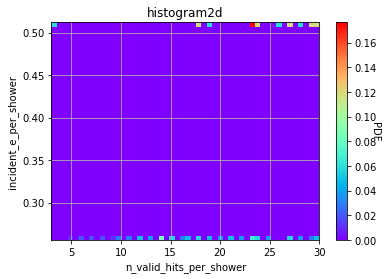

# batches: 2
Batch: 0
Generation batch 0: showers per batch: 64, max. hits per shower: 30, features per hit: 4, sampled_energies: 64
Progress: 1/2

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([64, 30, 4])
Batch: 1
Generation batch 1: showers per batch: 36, max. hits per shower: 30, features per hit: 4, sampled_energies: 36
Progress: 2/2

  0%|          | 0/100 [00:00<?, ?it/s]

sample: torch.Size([100, 30, 4])


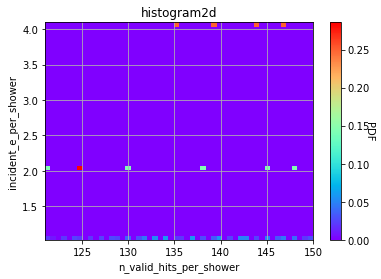

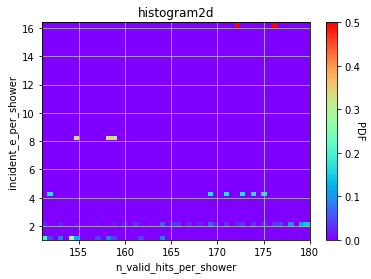

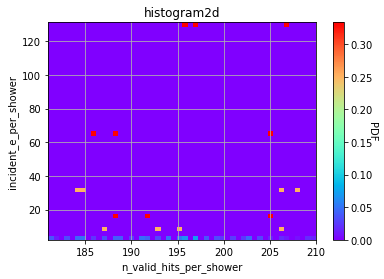

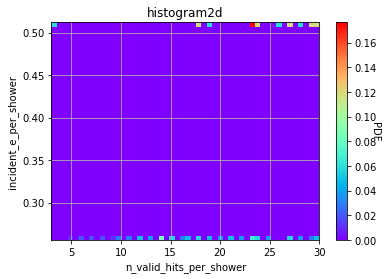

In [16]:
from IPython import display
from datetime import datetime
import functools, torch, os, sys, random
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tqdm
workingdir = "./"

# SAMPLE PARAMETERS
sampler_steps = 100
n_showers_2_gen = 100

print(f'batch_size: {batch_size}')

output_directory = workingdir+'/sampling_'+str(sampler_steps)+'samplersteps_'+datetime.now().strftime('%Y%m%d_%H%M')+'_output/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Load saved model
model.load_state_dict(torch.load('/eos/user/j/jthomasw/tdsm_encoder/training_20230825_1601_output/ckpt_tmp_499.pth', map_location=device))
model.to(device)

# N valid hits used for 2D PDF
#n_valid_hits_per_shower = np.array([])
# Incident particle energy for 2D PDF
#incident_e_per_shower = np.array([])
geant_deposited_energy = []
geant_x_pos = []
geant_y_pos = []
geant_ine = np.array([])
N_geant_showers = 0

print(f'Files: {files_list_}')

# For diffusion plots in 'physical' feature space, add files here
energy_trans_file = ''#os.path.join(files_list_[0].rsplit('/',1)[0],'transform_e.pkl')
x_trans_file = ''#os.path.join(files_list_[0].rsplit('/',1)[0],'transform_x.pkl')
y_trans_file = ''#os.path.join(files_list_[0].rsplit('/',1)[0],'transform_y.pkl')
ine_trans_file = ''#os.path.join(files_list_[0].rsplit('/',1)[0],'rescaler_y.pkl')

# Load saved pre-processor
if ine_trans_file != '':
    print(f'energy_trans_file: {energy_trans_file}')
    scalar_ine = load(open(ine_trans_file, 'rb'))
if energy_trans_file != '':
    scalar_e = load(open(energy_trans_file, 'rb'))
if x_trans_file != '':
    scalar_x = load(open(x_trans_file, 'rb'))
if y_trans_file != '':
    scalar_y = load(open(y_trans_file, 'rb'))

n_files = len(files_list_)
nshowers_per_file = [n_showers_2_gen//n_files for x in range(n_files)]
r_ = n_showers_2_gen % nshowers_per_file[0]
nshowers_per_file[-1] = nshowers_per_file[-1]+r_
print(f'# showers per file: {nshowers_per_file}')
shower_counter = 0

#sampled_ine = torch.tensor()

sample_ = []
pc_sampler = trans_tdsm.pc_sampler(sde=sde, padding_value=padding_value, snr=0.16, sampler_steps=sampler_steps, device=device, jupyternotebook=True)
# Collect Geant4 shower information
for file_idx in range(len(files_list_)):
    
    # N valid hits used for 2D PDF
    n_valid_hits_per_shower = np.array([])
    # Incident particle energy for 2D PDF
    incident_e_per_shower = np.array([])
    
    max_hits = -1
    file = files_list_[file_idx]
    print(f'file: {file}')
    shower_counter = 0
    
    # Load shower data
    custom_data = utils.cloud_dataset(file, device=device)
    point_clouds_loader = DataLoader(custom_data, batch_size=batch_size, shuffle=True)
    
    # Loop over batches
    for i, (shower_data, incident_energies) in enumerate(point_clouds_loader,0):
        # Copy data
        valid_event = []
        data_np = shower_data.cpu().numpy().copy()
        energy_np = incident_energies.cpu().numpy().copy()
        
        # Mask for padded values
        masking = data_np[:,:,0] != padding_value
        
        # Loop over each shower in batch
        for j in range(len(data_np)):
            
            # valid hits for shower j in batch used for GEANT plot distributions
            valid_hits = data_np[j]
            
            # real (unpadded) hit multiplicity needed for the 2D PDF later
            n_valid_hits = data_np[j][masking[j]]
            
            n_valid_hits_per_shower = np.append(n_valid_hits_per_shower, len(n_valid_hits))
            if len(valid_hits)>max_hits:
                max_hits = len(valid_hits)

            incident_e_per_shower = np.append(incident_e_per_shower, energy_np[j])
            
            # ONLY for plotting purposes
            if shower_counter >= nshowers_per_file[file_idx]:
                break
            else:
                shower_counter+=1

                #geant_ine = np.append(geant_ine, energy_np[j])
                all_ine = energy_np[j].reshape(-1,1)

                # Rescale the conditional input for each shower
                if ine_trans_file != '':
                    all_ine = scalar_ine.inverse_transform(all_ine)
                all_ine = all_ine.flatten()
                all_ine = all_ine.tolist()
                geant_ine = np.append(geant_ine,all_ine[0])
                
                all_e = valid_hits[:,0].reshape(-1,1)
                if energy_trans_file != '':
                    all_e = scalar_e.inverse_transform(all_e)
                all_e = all_e.flatten().tolist()
                geant_deposited_energy.append( sum( all_e ) )
                
                all_x = valid_hits[:,1].reshape(-1,1)
                if x_trans_file != '':
                    all_x = scalar_x.inverse_transform(all_x)
                all_x = all_x.flatten().tolist()
                geant_x_pos.append( np.mean(all_x) )
                
                all_y = valid_hits[:,2].reshape(-1,1)
                if y_trans_file != '':
                    all_y = scalar_y.inverse_transform(all_y)
                all_y = all_y.flatten().tolist()
                geant_y_pos.append( np.mean(all_y) )

            N_geant_showers+=1

    del custom_data
    print(f'max_hits: {max_hits}')

    # Arrays of Nvalid hits in showers, incident energies per shower
    n_valid_hits_per_shower = np.array(n_valid_hits_per_shower)
    incident_e_per_shower = np.array(incident_e_per_shower)
    #max_incident_e = max(incident_e_per_shower)
    #min_incident_e = min(incident_e_per_shower)

    # Generate 2D pdf of incident E vs N valid hits from the training file(s)
    n_bins_prob_dist = 50
    e_vs_nhits_prob, x_bin, y_bin = trans_tdsm.get_prob_dist(incident_e_per_shower, n_valid_hits_per_shower, n_bins_prob_dist)

    # Plot 2D histogram (sanity check)
    fig0, (ax0) = plt.subplots(ncols=1, sharey=True)
    dh0 = display.display(fig0, display_id=True)
    heatmap = ax0.pcolormesh(y_bin, x_bin, e_vs_nhits_prob, cmap='rainbow')
    ax0.plot(n_valid_hits_per_shower, n_valid_hits_per_shower, 'k-')
    ax0.set_xlim(n_valid_hits_per_shower.min(), n_valid_hits_per_shower.max())
    ax0.set_ylim(incident_e_per_shower.min(), incident_e_per_shower.max())
    ax0.set_xlabel('n_valid_hits_per_shower')
    ax0.set_ylabel('incident_e_per_shower')
    cbar = plt.colorbar(heatmap)
    cbar.ax.set_ylabel('PDF', rotation=270)
    ax0.set_title('histogram2d')
    ax0.grid()
    dh0.update(fig0)

    # Generate tensor sampled from the appropriate range of injection energies
    idx_list_incident_e = torch.randint(0, len(incident_e_per_shower), (n_showers_2_gen,))
    in_energies = torch.from_numpy(np.random.choice( incident_e_per_shower, n_showers_2_gen ))
    if file_idx == 0:
        sampled_ine = in_energies
    else:
        sampled_ine = torch.cat([sampled_ine,in_energies])

    # When generating, we should pad to different 'max hit' values
    # This means we need to create different files for each bucket again and then pad them
    
    # Create variable length tensors of random noise for features of hits
    nhits, gen_hits = trans_tdsm.generate_hits(e_vs_nhits_prob, x_bin, y_bin, in_energies, 4, device=device)

    # Save
    torch.save([gen_hits, in_energies],'tmp.pt')

    # Load the showers of noise
    gen_hits = utils.cloud_dataset('tmp.pt', device=device)

    # Pad showers to have equal length
    gen_hits.padding(padding_value)

    # Load len(gen_hits_loader) number of batches each with batch_size number of showers
    gen_hits_loader = DataLoader(gen_hits, batch_size=batch_size, shuffle=False)

    # Remove noise shower file
    os.system("rm tmp.pt")

    # Instantiate sampler
    sample = []
    #pc_sampler = trans_tdsm.pc_sampler(sde=sde, padding_value=padding_value, snr=0.16, sampler_steps=sampler_steps, device=device, jupyternotebook=True)

    # Loop over each batch of noise showers
    print(f'# batches: {len(gen_hits_loader)}' )
    for i, (gen_hit, sampled_energies) in enumerate(gen_hits_loader,0):
        print(f'Batch: {i}')
        print(f'Generation batch {i}: showers per batch: {gen_hit.shape[0]}, max. hits per shower: {gen_hit.shape[1]}, features per hit: {gen_hit.shape[2]}, sampled_energies: {len(sampled_energies)}')    
        sys.stdout.write('\r')
        sys.stdout.write("Progress: %d/%d" % ((i+1), len(gen_hits_loader)))
        sys.stdout.flush()

        # Run reverse diffusion sampler on showers of random noise + zero-padded hits
        generative = pc_sampler(model, marginal_prob_std_fn, diffusion_coeff_fn, sampled_energies, gen_hit, batch_size=gen_hit.shape[0], energy_trans_file=energy_trans_file, x_trans_file=x_trans_file , y_trans_file = y_trans_file, ine_trans_file=ine_trans_file)

        # Create first sample or concatenate sample to sample list
        if i == 0:
            sample = generative
        else:
            sample = torch.cat([sample,generative])

        print(f'sample: {sample.shape}')

    #sample_ = []
    sample_np = sample.cpu().numpy()

    for i in range(len(sample_np)):
        # The output of the sampler has nhits == max hits (do we want to remove these here or during the diffusion?)
        tmp_sample = sample_np[i]#[:nhits[i]]  # This seems like a bit of a botch?
        sample_.append(torch.tensor(tmp_sample))

torch.save([sample_,sampled_ine], os.path.join(output_directory, 'sample.pt'))


## Studying the diffusion

No we make some plots of our various features in order to study how the diffusion affects our predicitions. Note that for the generated distributions we use the predefined sampler variables that store arrays of the variable at given time steps. One should check these time steps are the ones you wish to study i.e. is 't99' really set to the last time step or did you take more than 100 time steps? In which case, this isn't the end result of the diffusion model.

plt.axis(): (0.0, 28.35, 0.014368011554082235, 1.5234236558278402)
save_name: .//sampling_100samplersteps_20230828_1713_output/ShowerMeanX_ShowerMeanY.png
plt.axis(): (0.0, 17.85, -1.4078107122331858, 320.4873149394989)
save_name: .//sampling_100samplersteps_20230828_1713_output/ShowerMeanX_TotaldepositedenergyGeV.png
plt.axis(): (0.0, 157.5, 0.25600001215934753, 65.53600311279297)
save_name: .//sampling_100samplersteps_20230828_1713_output/Totaldepositedenergy_IncidentparticleenergyGeV.png


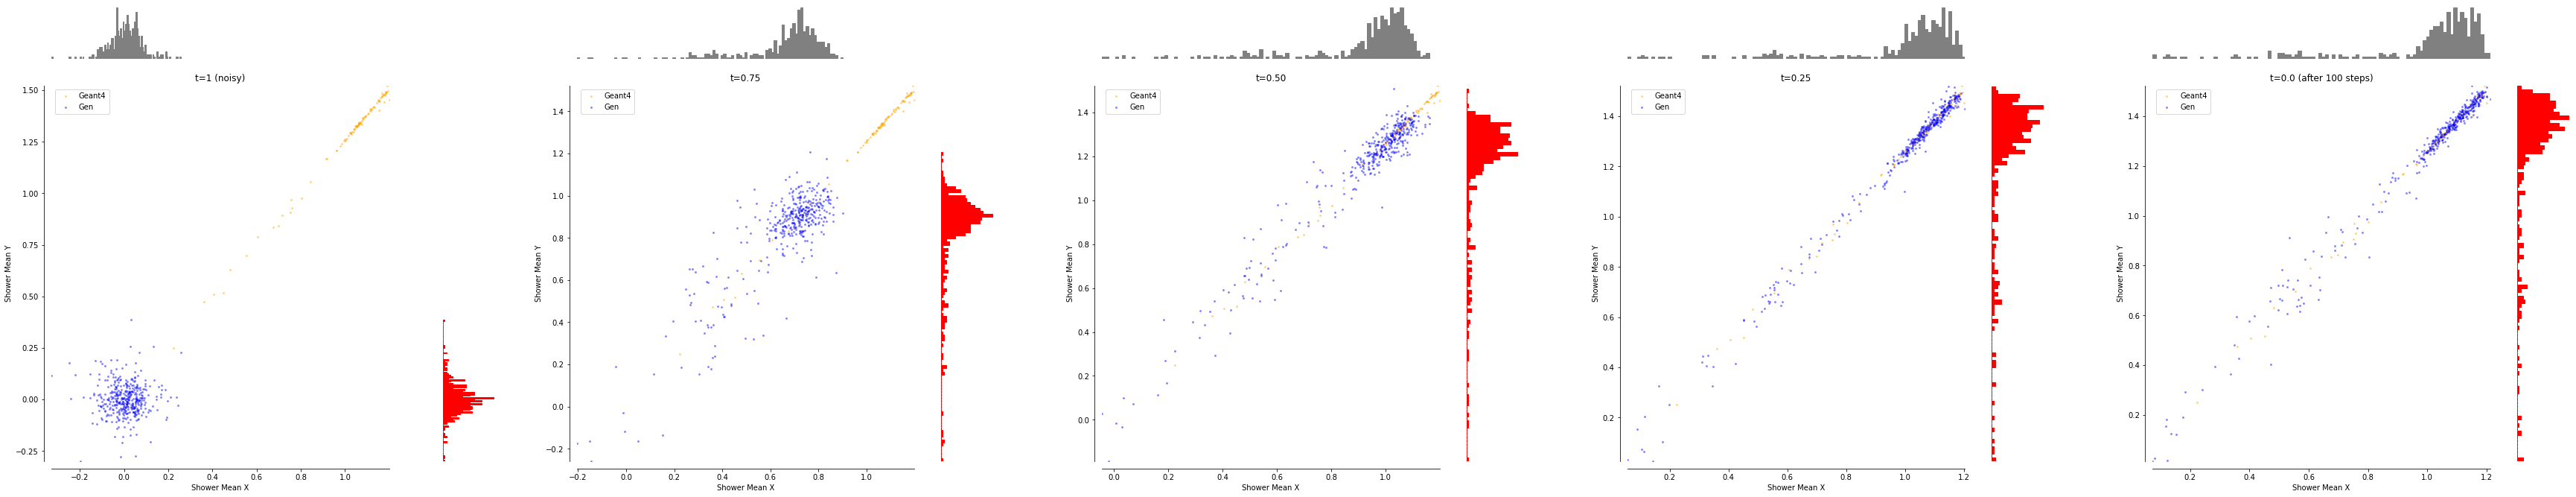

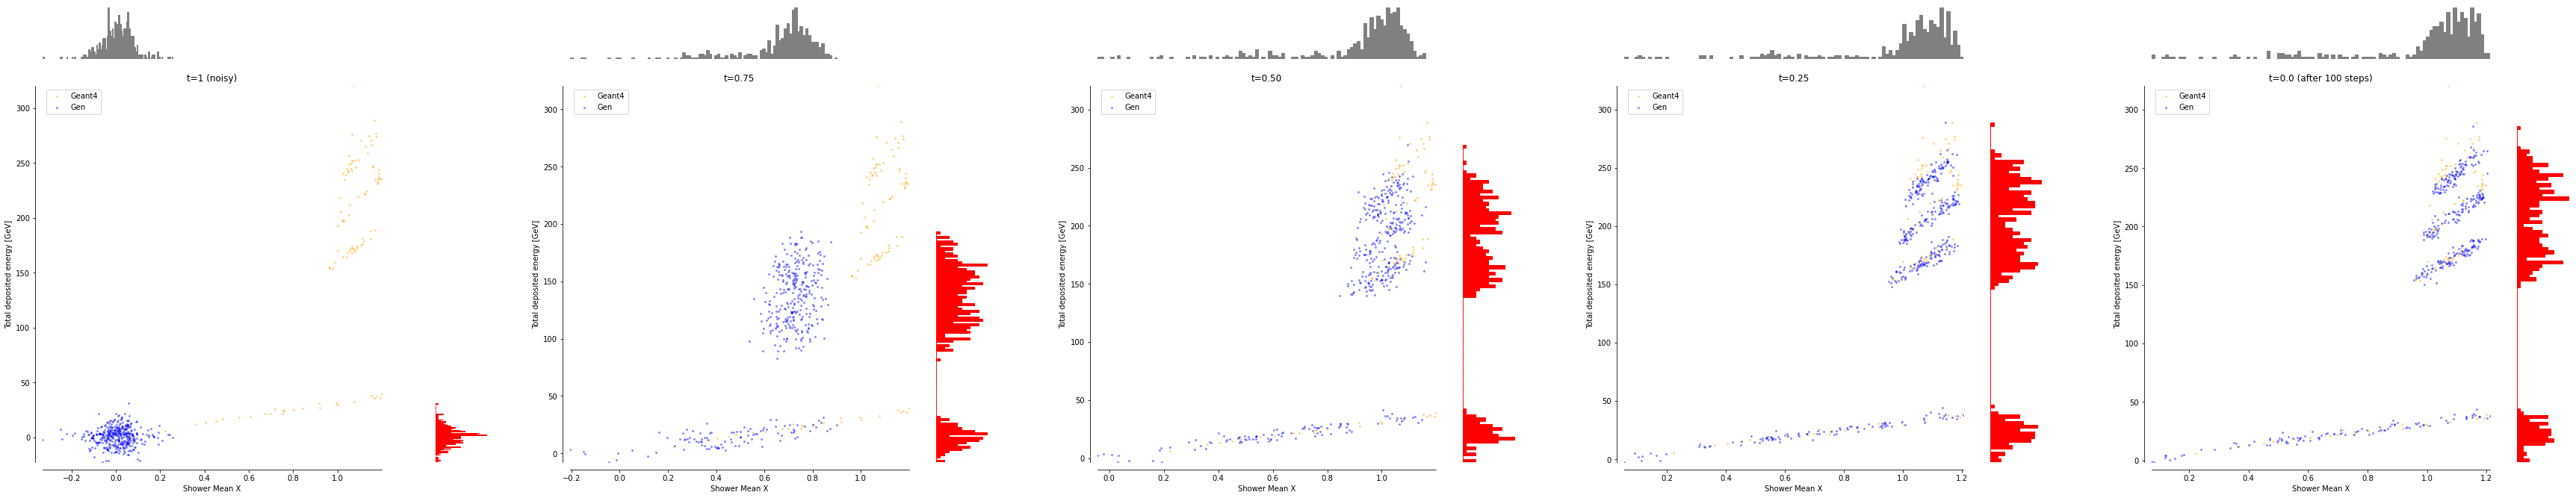

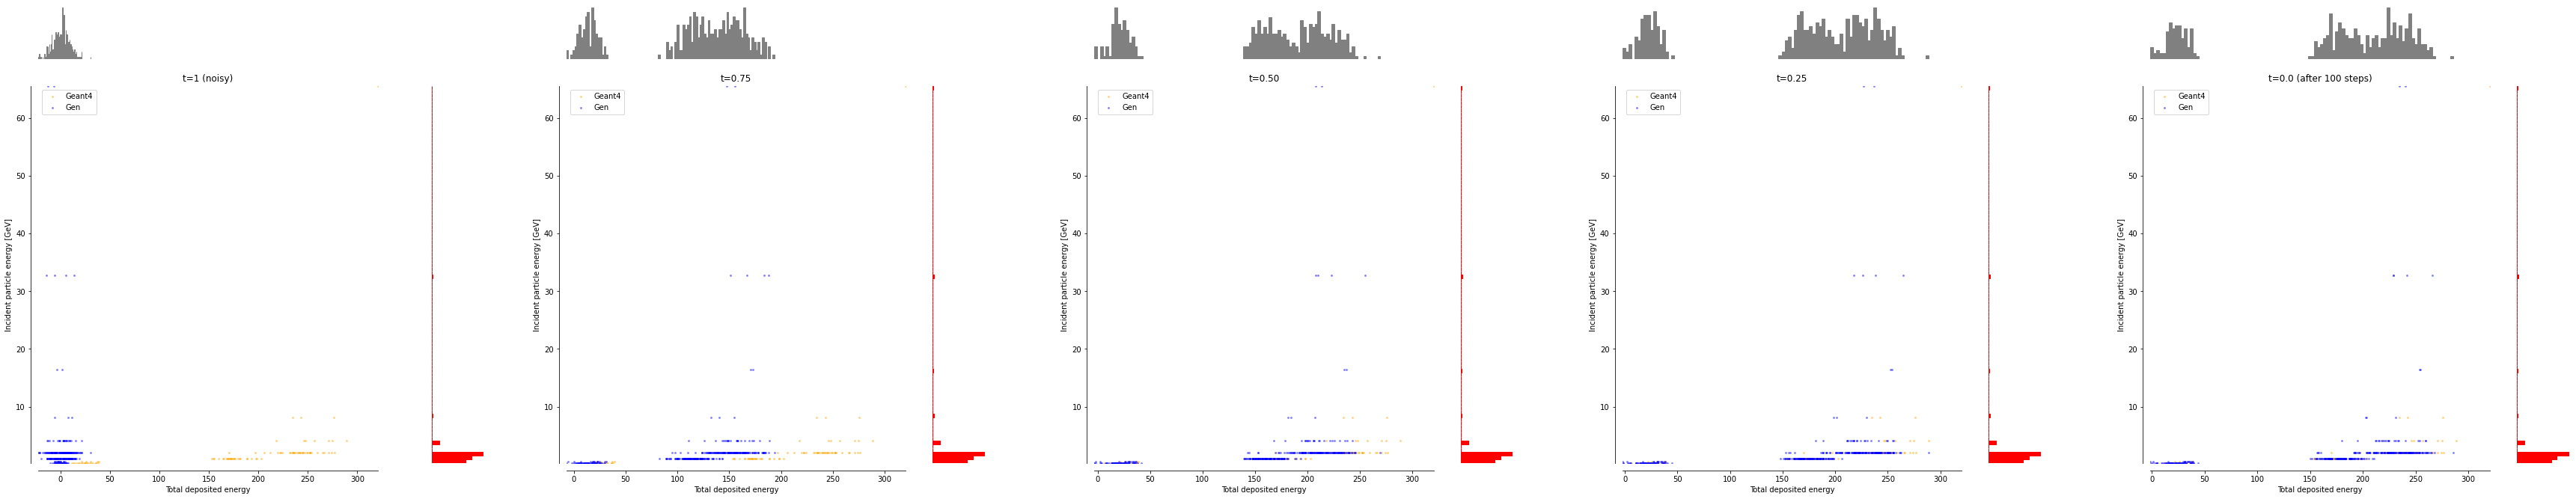

In [17]:
if jupyternotebook:
    
    # Create plots of distributions evolving with diffusion steps
    distributions = [
        ( ('Shower Mean X', 'Shower Mean Y'), 
        (geant_x_pos,
        geant_y_pos,
        pc_sampler.av_x_pos_step1,
        pc_sampler.av_y_pos_step1, 
        pc_sampler.av_x_pos_step25,
        pc_sampler.av_y_pos_step25,
        pc_sampler.av_x_pos_step50,
        pc_sampler.av_y_pos_step50,
        pc_sampler.av_x_pos_step75,
        pc_sampler.av_y_pos_step75,
        pc_sampler.av_x_pos_step99,
        pc_sampler.av_y_pos_step99) )
    ]
    util.display.make_diffusion_plot(distributions, output_directory)
        
    distributions = [
        ( ('Shower Mean X', 'Total deposited energy [GeV]'), 
        (geant_x_pos,
        geant_deposited_energy,
        pc_sampler.av_x_pos_step1,
        pc_sampler.deposited_energy_step1, 
        pc_sampler.av_x_pos_step25,
        pc_sampler.deposited_energy_step25,
        pc_sampler.av_x_pos_step50,
        pc_sampler.deposited_energy_step50,
        pc_sampler.av_x_pos_step75,
        pc_sampler.deposited_energy_step75,
        pc_sampler.av_x_pos_step99,
        pc_sampler.deposited_energy_step99) )
    ]
    util.display.make_diffusion_plot(distributions, output_directory)
    
    distributions = [
        ( ('Total deposited energy', 'Incident particle energy [GeV]'), 
        (geant_deposited_energy,
        geant_ine,
        pc_sampler.deposited_energy_step1,
        pc_sampler.incident_e_step1,
        pc_sampler.deposited_energy_step25,
        pc_sampler.incident_e_step25,
        pc_sampler.deposited_energy_step50,
        pc_sampler.incident_e_step50,
        pc_sampler.deposited_energy_step75,
        pc_sampler.incident_e_step75,
        pc_sampler.deposited_energy_step99,
        pc_sampler.incident_e_step99) )
    ]
    util.display.make_diffusion_plot(distributions,output_directory)



## Draw Generative Distribution
We now comparisons of several features from the original GEANT4 dataset, and from showers generated in our diffusion model.

Generated inputs
# showers to plot: 100
plot_distribution running on input type 'cloud_dataset'
Geant4 inputs
# showers to plot: 100
plot_distribution running on input type 'files'
# files: 4
# showers per file: [25, 25, 25, 25]
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry121To150.pt
# batches: 14635
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry151To180.pt
# batches: 6171
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry181To210.pt
# batches: 16473
File: /eos/user/j/jthomasw/tdsm_encoder/datasets/test_3/dataset_1_photons_padded_nentry1To30.pt
# batches: 6176
Plot # entries
entries: 100
entries_gen: 100
Plot hit energies
Plot hit x
Plot hit y
Plot hit z
Plot incident energies
Plot total deposited hit energy
Plot average hit X position
Plot average hit Y position


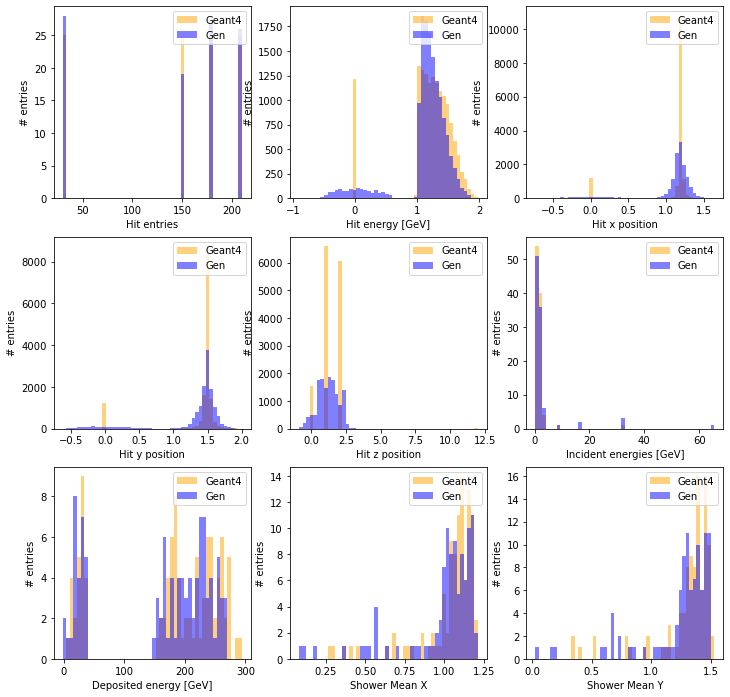

In [18]:
import utils, sys
#sys.path.insert(1, '../')
import util.display

# Ensure plots contain the same number of showers for Geant4 and the generated sample
n_showers_2_gen =  100

# Distributions object for generated files
print(f'Generated inputs')
output_directory = 'sampling_100samplersteps_20230828_1713_output'
plot_file_name = os.path.join(output_directory, 'sample.pt')
custom_data = utils.cloud_dataset(plot_file_name,device=device)
# When providing just cloud dataset, energy_trans_file needs to include full path
dists_gen = util.display.plot_distribution(custom_data, nshowers_2_plot=n_showers_2_gen,padding_value=padding_value)

entries_gen = dists_gen[0]
all_incident_e_gen = dists_gen[1]
total_deposited_e_shower_gen = dists_gen[2]
all_e_gen = dists_gen[3]
all_x_gen = dists_gen[4]
all_y_gen = dists_gen[5]
all_z_gen = dists_gen[6]
all_hit_ine_gen = dists_gen[7]
average_x_shower_gen = dists_gen[8]
average_y_shower_gen = dists_gen[9]

print(f'Geant4 inputs')
# Distributions object for Geant4 files
dists = util.display.plot_distribution(files_list_, nshowers_2_plot=n_showers_2_gen,padding_value=padding_value)

entries = dists[0]
all_incident_e = dists[1]
total_deposited_e_shower = dists[2]
all_e = dists[3]
all_x = dists[4]
all_y = dists[5]
all_z = dists[6]
all_hit_ine_geant = dists[7]
average_x_shower_geant = dists[8]
average_y_shower_geant = dists[9]

print('Plot # entries')
print(f'entries: {len(entries)}')
print(f'entries_gen: {len(entries_gen)}')
bins=np.histogram(np.hstack((entries,entries_gen)), bins=50)[1]
fig, ax = plt.subplots(3,3, figsize=(12,12))
ax[0][0].set_ylabel('# entries')
ax[0][0].set_xlabel('Hit entries')
ax[0][0].hist(entries, bins, alpha=0.5, color='orange', label='Geant4')
ax[0][0].hist(entries_gen, bins, alpha=0.5, color='blue', label='Gen')
ax[0][0].legend(loc='upper right')

print('Plot hit energies')
bins=np.histogram(np.hstack((all_e,all_e_gen)), bins=50)[1]
ax[0][1].set_ylabel('# entries')
ax[0][1].set_xlabel('Hit energy [GeV]')
ax[0][1].hist(all_e, bins, alpha=0.5, color='orange', label='Geant4')
ax[0][1].hist(all_e_gen, bins, alpha=0.5, color='blue', label='Gen')
#ax[0][1].set_yscale('log')
ax[0][1].legend(loc='upper right')

print('Plot hit x')
bins=np.histogram(np.hstack((all_x,all_x_gen)), bins=50)[1]
ax[0][2].set_ylabel('# entries')
ax[0][2].set_xlabel('Hit x position')
ax[0][2].hist(all_x, bins, alpha=0.5, color='orange', label='Geant4')
ax[0][2].hist(all_x_gen, bins, alpha=0.5, color='blue', label='Gen')
#ax[0][2].set_yscale('log')
ax[0][2].legend(loc='upper right')

print('Plot hit y')
bins=np.histogram(np.hstack((all_y,all_y_gen)), bins=50)[1]
ax[1][0].set_ylabel('# entries')
ax[1][0].set_xlabel('Hit y position')
ax[1][0].hist(all_y, bins, alpha=0.5, color='orange', label='Geant4')
ax[1][0].hist(all_y_gen, bins, alpha=0.5, color='blue', label='Gen')
#ax[1][0].set_yscale('log')
ax[1][0].legend(loc='upper right')

print('Plot hit z')
bins=np.histogram(np.hstack((all_z,all_z_gen)), bins=50)[1]
ax[1][1].set_ylabel('# entries')
ax[1][1].set_xlabel('Hit z position')
ax[1][1].hist(all_z, bins, alpha=0.5, color='orange', label='Geant4')
ax[1][1].hist(all_z_gen, bins, alpha=0.5, color='blue', label='Gen')
#ax[1][1].set_yscale('log')
ax[1][1].legend(loc='upper right')

print('Plot incident energies')
bins=np.histogram(np.hstack((all_incident_e,all_incident_e_gen)), bins=50)[1]
ax[1][2].set_ylabel('# entries')
ax[1][2].set_xlabel('Incident energies [GeV]')
ax[1][2].hist(all_incident_e, bins, alpha=0.5, color='orange', label='Geant4')
ax[1][2].hist(all_incident_e_gen, bins, alpha=0.5, color='blue', label='Gen')
#ax[1][2].set_yscale('log')
ax[1][2].legend(loc='upper right')

print('Plot total deposited hit energy')
bins=np.histogram(np.hstack((total_deposited_e_shower,total_deposited_e_shower_gen)), bins=50)[1]
ax[2][0].set_ylabel('# entries')
ax[2][0].set_xlabel('Deposited energy [GeV]')
ax[2][0].hist(total_deposited_e_shower, bins, alpha=0.5, color='orange', label='Geant4')
ax[2][0].hist(total_deposited_e_shower_gen, bins, alpha=0.5, color='blue', label='Gen')
#ax[2][0].set_yscale('log')
ax[2][0].legend(loc='upper right')

print('Plot average hit X position')
bins=np.histogram(np.hstack((average_x_shower_geant,average_x_shower_gen)), bins=50)[1]
ax[2][1].set_ylabel('# entries')
ax[2][1].set_xlabel('Shower Mean X')
ax[2][1].hist(average_x_shower_geant, bins, alpha=0.5, color='orange', label='Geant4')
ax[2][1].hist(average_x_shower_gen, bins, alpha=0.5, color='blue', label='Gen')
#ax[2][1].set_yscale('log')
ax[2][1].legend(loc='upper right')

print('Plot average hit Y position')
bins=np.histogram(np.hstack((average_y_shower_geant,average_y_shower_gen)), bins=50)[1]
ax[2][2].set_ylabel('# entries')
ax[2][2].set_xlabel('Shower Mean Y')
ax[2][2].hist(average_y_shower_geant, bins, alpha=0.5, color='orange', label='Geant4')
ax[2][2].hist(average_y_shower_gen, bins, alpha=0.5, color='blue', label='Gen')
#ax[2][2].set_yscale('log')
ax[2][2].legend(loc='upper right')

fig.show()

fig_name = os.path.join(output_directory, 'Geant_Gen_comparison.png')
fig.savefig(fig_name)